In [2]:
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as DCUtils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# from PGI_DC_example_Utils import plot_pseudoSection, getCylinderPoints

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

3.10.11 | packaged by Anaconda, Inc. | (main, May 16 2023, 00:55:32) [MSC v.1916 64 bit (AMD64)]


In [3]:
# 2D Mesh
#########
csx,  csy,  csz = 0.25,  0.25,  0.25
# Number of core cells in each direction
ncx,  ncz = 123,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

# 2-cylinders Model Creation
##########################
# Spheres parameters
x0,  z0,  r0 = -6.,  -5.,  3.
x1,  z1,  r1 = 6.,  -5.,  3.

ln_sigback = -np.log(500.)
ln_sigc = -np.log(90.)
ln_sigr = -np.log(50.)

# Add some variability to the physical property model
noisemean = 0.
noisevar = np.sqrt(0.001)
ln_over = -2.

mtrue = ln_sigback * np.ones(mesh.nC) + norm(noisemean, noisevar).rvs(mesh.nC)
mprim = copy.deepcopy(mtrue)

csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

# Define the sphere limit
rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

# sphere smaller but higher conductivity
csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
    norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))


mtrue = utils.mkvc(mtrue)
xmin,  xmax = -15., 15
ymin,  ymax = -15., 0.
#xmin,  xmax = mesh.vectorNx.min(), mesh.vectorNx.max()
#ymin,  ymax = mesh.vectorNy.min(), mesh.vectorNy.max()
print(xmin,xmax,ymin,ymax)
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = discretize.utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)

-15.0 15 -15.0 0.0


C:\Users\johnk\AppData\Local\Temp\ipykernel_1788\2793981791.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(mtrue[actcore], ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral"})
c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\discretize\utils\code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


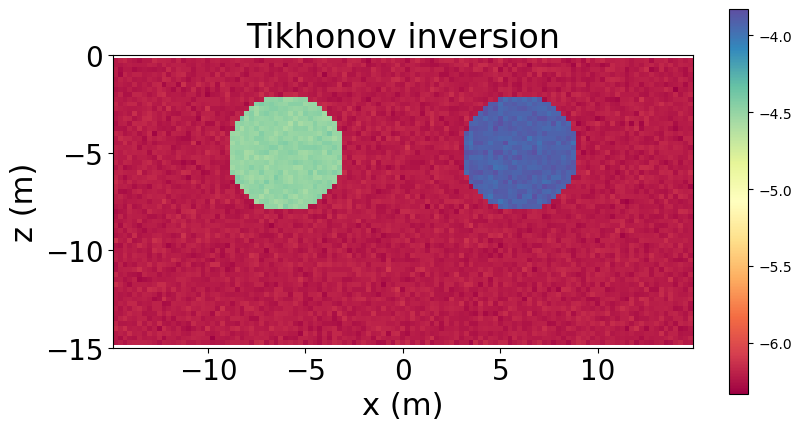

In [4]:
clim = [mtrue.min(), mtrue.max()]

fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mtrue[actcore], ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral"})
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.colorbar(dat[0])
plt.show()

In [5]:
# Setup a Dipole-Dipole Survey with 1m and 2m dipoles
xmin, xmax = -15., 15.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
survey1 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=1, b=1, n=16, d2flag='2.5D'
)
survey2 = DCUtils.generate_dcip_survey(
    endl, survey_type="dipole-dipole", dim=mesh.dim,
    a=2, b=2, n=16, d2flag='2.5D'
)

survey = dc.Survey(survey1.source_list + survey2.source_list)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    mesh=mesh,  indActive=actcore,
    valInactive=-np.log(1e8)
)
mapping = expmap * mapactive
sim = dc.Simulation2DNodal(
    mesh,
    survey,
    sigmaMap=mapping,
    storeJ=True,
    solver=Solver
)


std = 0.02
# survey.dpred(mtrue[actcore])
dpred = sim.make_synthetic_data(mtrue[actcore], relative_error=std, force=True)
survey.eps = 1e-4

m0 = -np.log(np.median((DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs)))) * np.ones(mapping.nP)

# expmap = Maps.ExpMap(mesh)
# mapactive = Maps.InjectActiveCells(
#     mesh=mesh,  indActive=actcore,
#     valInactive=np.unique(m0)
# )
# mapping = expmap * mapactive
# problem = DC.Problem2D_N(mesh,  sigmaMap=mapping, storeJ=True)
# survey.unpair()
# problem.pair(survey)
# problem.Solver = PardisoSolver

c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\SimPEG\electromagnetics\static\resistivity\simulation_2d.py:755: RuntimeWarning: invalid value encountered in divide
  r_hat = r_vec / r[:, None]
c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\SimPEG\electromagnetics\static\resistivity\simulation_2d.py:782: RuntimeWarning: invalid value encountered in divide
  alpha[not_top] = (ky * k1e(ky * r) / k0e(ky * r) * r_dot_n)[not_top]


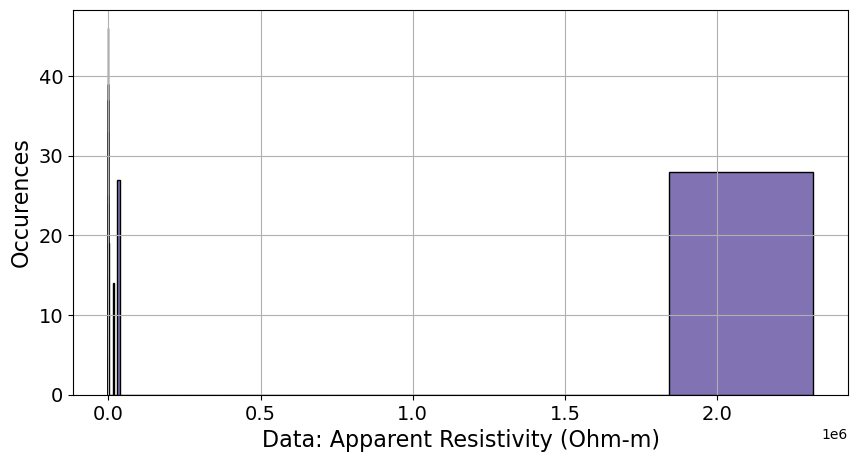

In [6]:
# Plot the histogram of the data
fig, ax = plt.subplots(1,1,figsize=(10,5))
hist, edges = np.histogram(-np.log(((DCUtils.apparent_resistivity_from_voltage(survey, dpred.dobs)))),bins=50, density=False)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",color='#8172B3');
# ax.plot((1./np.exp(-4.72760309)*np.ones(2)),[0,50],linestyle='dashed',linewidth=2.,c='k')
# ax.text(115,30,'Starting half-space\nwhen no mean\npetrophysical information\nis available',fontsize=16)
# ax.plot(100.*np.ones(2),[0,50],linestyle='dashed',linewidth=2.,c='k')
# ax.text(98,20,'True\nbackground\nmean',fontsize=16,ha='right')
ax.grid(True,which='both')
ax.grid(True,which="major",ls="-")

ax.set_xlabel('Data: Apparent Resistivity (Ohm-m)',fontsize=16)
ax.tick_params(labelsize=14)
ax.set_ylabel('Occurences',fontsize=16)
# ax.set_xticks(np.r_[75,100,125,150])
plt.show()

In [7]:
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)

# class samClassificationModel():

#     def __init__(
#         self,
#         segmentation_model_checkpoint: str=r"C:\Users\johnk\Documents\git\jresearch\PGI\dcip\sam_vit_h_4b8939.pth",
#     ):
        
#         self.segmentation_model_checkpoint = segmentation_model_checkpoint

#         # load segmentation network model
#         sam = sam_model_registry["vit_h"](checkpoint=self.segmentation_model_checkpoint)
#         self.mask_generator = SamAutomaticMaskGenerator(sam)

#     def fit(model:np.ndarray=None):

#         if model is None:

#             return None
        
#         else:

#             model_normalized = np.exp(model) / np.abs(np.exp(model)).max()

#             image_rgb = Image.fromarray(np.uint8(cm.jet(model_normalized.reshape(self.mesh.shape_cells, order='F'))*255))
#             image_rgb = image_rgb.convert('RGB')

#             result = self.mask_generator.generate(np.asarray(image_rgb))


#             # ---------------------------------------------------------------------------------------------

#             # create a matrix that holds information about overlapping mask if they happen to

#             # this is done using intersection over union method

#             #

#             nlayers = len(result)

#             union_matrix = np.zeros((nlayers, nlayers))
#             for ii in range(nlayers):
#                 for jj in range(nlayers):
#                     iou_score = calculate_iou(result[ii]['segmentation'], result[jj]['segmentation'])
#                     union_matrix[ii, jj] = iou_score
#                     print("IoU score:", iou_score)

#             # ------------------------------------------------------------------------------------

#             # modify the overlap matrix to assign the proper neighbors mask in the case of onions

#             #

#             sub_union_matrix = union_matrix[1:, 1:].copy()

#             # calculate how many non zero in a row of our overlap matrix
#             for jj in range(sub_union_matrix.shape[0]):

#                 if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

#                     mask_index = np.nonzero(sub_union_matrix[jj, :])
#                     print(mask_index[0][-1])
#                     # check which mask is larger
#                     result[mask_select]['segmentation']
#                     sub_union_matrix[jj, mask_index[0][-1]] = 1
#                     sub_union_matrix[jj, mask_index[0][0]] = 0

#             # --------------------------------------------------------------------------------------

#             # assign each cell a mask to assign it's neighbors

#             #

#             hx, hy = self.mesh.shape_cells
#             x = np.arange(hx)
#             y = np.arange(hy)
#             xx, yy = np.meshgrid(x, y)

#             mask_locations = np.vstack([xx.flatten(), yy.flatten()])

#             mask_assignment = np.zeros(mask_locations.shape[1])

#             for ii in range(mask_locations.shape[1]):

#                 for jj in range(nlayers - 1):

#                     idx = np.vstack(np.where(result[jj + 1]['segmentation'] == True))

#                     point_set = idx.T

#                     # print(point_set.shape, np.vstack(idx).shape, xx.shape)
#                     distances = np.sqrt(np.sum((point_set - mask_locations[:, ii].T)**2, axis=1))
#                     # print(jj, mask_assignment[:, ii].T, point_set[0, :])
#                     min_distance = np.min(distances)
                    
#                     if min_distance == 0:
#                         mask_assignment[ii] = jj + 1

#             # ----------------------------------------------------------------------------------------

#             # now update the indexpoint matrix

#             #

#             for kk in range(mask_assignment.shape[0]):

#                 # check union matrix for the correct mask
#                 union_index = int(mask_assignment[kk] - 1)
#                 print(union_index, sub_union_matrix.shape)
#                 if union_index < 0:

#                     pass

#                 else:
#                     print(sub_union_matrix[union_index, :])
#                     mask_select = np.nonzero(sub_union_matrix[union_index, :])[0][0]

#                     idx = np.vstack(np.where(result[mask_select]['segmentation'].flatten(order='F') == True))[0]
#                     shape_idx = idx.shape[0]

#                     # if the mask is smaller than the user defined number of neighbors
#                     if idx.shape[0] < (self.kneighbors + 1):

#                         self.indexpoint[kk, :] = self.indexpoint[kk, 0]
#                         self.indexpoint[kk, -shape_idx:] = idx

#                     # otherwise assign the entire mask
#                     else:

#                         print(f"idx shape: {idx.shape} knei: {self.kneighbors} {shape_idx} {self.indexpoint.shape} {kk}")
#                         print(idx[:(self.kneighbors + 1)].shape, mask_locations.shape, mask_assignment.shape)
#                         self.indexpoint[kk, :] = idx[:(self.kneighbors + 1)]

#             self.masks = result

#     def predict(model:np.ndarry):


def calculate_iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) between two binary masks.

    Parameters:
        mask1 (numpy.ndarray): The first binary mask.
        mask2 (numpy.ndarray): The second binary mask.

    Returns:
        float: The Intersection over Union (IoU) score.
    """
    
    # Ensure the masks have the same shape
    if mask1.shape != mask2.shape:
        raise ValueError("Mask shapes do not match.")

    # Convert masks to binary (0 or 1) values
    mask1 = np.array(mask1 > 0, dtype=np.uint8)
    mask2 = np.array(mask2 > 0, dtype=np.uint8)

    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    iou = intersection / union if union > 0 else 0.0
    return iou


class GaussianMixtureMarkovRandomField(utils.WeightedGaussianMixture):

    def __init__(
        self,
        n_components,
        mesh,
        actv=None,
        kdtree=None,
        indexneighbors=None,
        boreholeidx=None,
        T=12.,
        masks=None,
        kneighbors=0,
        norm=2,
        init_params='kmeans',
        max_iter=100,
        covariance_type='full',
        means_init=None,
        n_init=10, 
        precisions_init=None,
        random_state=None, 
        reg_covar=1e-06, 
        tol=0.001, 
        verbose=0,
        verbose_interval=10, 
        warm_start=False, 
        weights_init=None,
        anisotropy=None,
        index_anisotropy=None, # Dictionary with anisotropy and index
        index_kdtree=None,# List of KDtree
        segmentation_model_checkpoint=r"C:\Users\johnk\Documents\git\jresearch\PGI\dcip\sam_vit_h_4b8939.pth",
        #**kwargs
    ):

        super(GaussianMixtureMarkovRandomField, self).__init__(
            n_components=n_components,
            mesh=mesh,
            actv=actv,
            covariance_type=covariance_type,
            init_params=init_params,
            max_iter=max_iter,
            means_init=means_init,
            n_init=n_init,
            precisions_init=precisions_init,
            random_state=random_state,
            reg_covar=reg_covar,
            tol=tol,
            verbose=verbose,
            verbose_interval=verbose_interval,
            warm_start=warm_start,
            weights_init=weights_init,
            #boreholeidx=boreholeidx
            # **kwargs
        )
        # setKwargs(self, **kwargs)
        self.kneighbors = kneighbors
        self.T = T
        self.boreholeidx = boreholeidx
        self.anisotropy = anisotropy
        self.norm = norm
        self.masks = masks
        self.mask_assignment = None
        self.segmentation_model_checkpoint = segmentation_model_checkpoint

        # load segmentation network model
        sam = sam_model_registry["vit_h"](checkpoint=self.segmentation_model_checkpoint)
        self.mask_generator = SamAutomaticMaskGenerator(sam)

        if self.mesh.gridCC.ndim == 1:
            xyz = np.c_[self.mesh.gridCC]
        elif self.anisotropy is not None:
            xyz = self.anisotropy.dot(self.mesh.gridCC.T).T
        else:
            xyz = self.mesh.gridCC
        
        if self.actv is None:
            self.xyz = xyz
        else:
            self.xyz = xyz[self.actv]
        
        if kdtree is None:
            print('Computing KDTree, it may take several minutes.')
            self.kdtree = spatial.KDTree(self.xyz)
        else:
            self.kdtree = kdtree
        
        if indexneighbors is None:
            print('Computing neighbors, it may take several minutes.')
            _, self.indexneighbors = self.kdtree.query(self.xyz, k=self.kneighbors+1, p=self.norm)
        else:
            self.indexneighbors = indexneighbors

        self.indexpoint = copy.deepcopy(self.indexneighbors)
        self.index_anisotropy = index_anisotropy
        self.index_kdtree = index_kdtree
        if self.index_anisotropy is not None and self.mesh.gridCC.ndim != 1:

            self.unitxyz = []
            for i, anis in enumerate(self.index_anisotropy['anisotropy']):
                self.unitxyz.append((anis).dot(self.xyz.T).T)

            if self.index_kdtree is None:
                self.index_kdtree = []
                print('Computing rock unit specific KDTree, it may take several minutes.')
                for i, anis in enumerate(self.index_anisotropy['anisotropy']):
                    self.index_kdtree.append(spatial.KDTree(self.unitxyz[i]))

            #print('Computing new neighbors based on rock units, it may take several minutes.')
            #for i, unitindex in enumerate(self.index_anisotropy['index']):
        #        _, self.indexpoint[unitindex] = self.index_kdtree[i].query(self.unitxyz[i][unitindex], k=self.kneighbors+1)

    def update_neighbors_index(
            
            self,
            model:np.ndarray
            
    ) -> None:
        """
        
            method that segments the input model and assigns new neighbors described
            by the segmentation map

            :param model: geophysical model
            :type model: np.ndarray

        """

        model_normalized = np.exp(model) / np.abs(np.exp(model)).max()

        image_rgb = Image.fromarray(np.uint8(cm.jet(model_normalized.reshape(self.mesh.shape_cells, order='F'))*255))
        image_rgb = image_rgb.convert('RGB')

        result = self.mask_generator.generate(np.asarray(image_rgb))


        # ---------------------------------------------------------------------------------------------

        # create a matrix that holds information about overlapping mask if they happen to

        # this is done using intersection over union method

        #

        nlayers = len(result)

        union_matrix = np.zeros((nlayers, nlayers))
        for ii in range(nlayers):
            for jj in range(nlayers):
                iou_score = calculate_iou(result[ii]['segmentation'], result[jj]['segmentation'])
                union_matrix[ii, jj] = iou_score
                # print("IoU score:", iou_score)

        # ------------------------------------------------------------------------------------

        # modify the overlap matrix to assign the proper neighbors mask in the case of onions

        #

        sub_union_matrix = union_matrix[1:, 1:].copy()
        # print(f"before sub-union: {sub_union_matrix}\n\n")

        removal = []

        # check if masks have to be removed
        for jj in range(sub_union_matrix.shape[0]):
            
            if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

                mask_index = np.nonzero(sub_union_matrix[jj, :])
                
                if mask_index[0].shape[0] == sub_union_matrix.shape[1]:
                    print("\n\n removal\n\n")
                    removal.append(jj)

        if len(removal) > 0:

            for indx in removal:

                result.pop(indx + 1)
                sub_union_matrix = np.delete(sub_union_matrix, indx, 0)
                sub_union_matrix = np.delete(sub_union_matrix, indx, 1)

        # print(f"modified sub-union: {sub_union_matrix}\n\n")

        # calculate how many non zero in a row of our overlap matrix
        for jj in range(sub_union_matrix.shape[0]):

            if np.count_nonzero(sub_union_matrix[jj, :]) > 1:

                mask_index = np.nonzero(sub_union_matrix[jj, :])
                # print(mask_index[0][-1])
                sub_union_matrix[jj, mask_index[0][-1]] = 1
                sub_union_matrix[jj, mask_index[0][0]] = 0

        # print(f"sub-union: {sub_union_matrix}\n\n")
        # --------------------------------------------------------------------------------------

        # assign each cell a mask to assign it's neighbors

        #

        nlayers = len(result)

        hx, hy = self.mesh.shape_cells
        x = np.arange(hx)
        y = np.arange(hy)
        xx, yy = np.meshgrid(x, y)

        mask_locations = np.vstack([xx.flatten(), yy.flatten()])

        mask_assignment = np.zeros(mask_locations.shape[1])

        for ii in range(mask_locations.shape[1]):

            for jj in range(nlayers - 1):

                idx = np.vstack(np.where(result[jj + 1]['segmentation'] == True))

                point_set = idx.T

                # print(point_set.shape, np.vstack(idx).shape, xx.shape)
                distances = np.sqrt(np.sum((point_set - mask_locations[:, ii].T)**2, axis=1))
                # print(jj, mask_assignment[:, ii].T, point_set[0, :])
                min_distance = np.min(distances)
                
                if min_distance == 0:

                    # find which mask to assign
                    idx1 = np.nonzero(sub_union_matrix[jj, :])
                    mask_assignment[ii] = idx1[0][0] + 1

        # plt.hist(mask_assignment, 100)
        # plt.show()
        # ----------------------------------------------------------------------------------------

        # now update the indexpoint matrix

        #

        for kk in range(mask_assignment.shape[0]):

            # check union matrix for the correct mask
            union_index = int(mask_assignment[kk])
            # print(union_index, sub_union_matrix.shape)
            if union_index < 0:

                pass

            else:
                # print(sub_union_matrix[union_index, :])
                mask_select = union_index

                idx = np.vstack(np.where(result[mask_select]['segmentation'].flatten(order='F') == True))[0]
                shape_idx = idx.shape[0]

                # if the mask is smaller than the user defined number of neighbors
                if idx.shape[0] < (self.kneighbors + 1):

                    self.indexpoint[kk, :] = self.indexpoint[kk, 0]
                    self.indexpoint[kk, -shape_idx:] = idx

                # otherwise assign the entire mask
                else:

                    # print(f"idx shape: {idx.shape} knei: {self.kneighbors} {shape_idx} {self.indexpoint.shape} {kk}")
                    # print(idx[:(self.kneighbors + 1)].shape, mask_locations.shape, mask_assignment.shape)
                    self.indexpoint[kk, :] = idx[:(self.kneighbors + 1)]

        self.masks = result
        self.sub_union_matrix = sub_union_matrix
        # print(np.bincount(onion.flatten()))

        # fig, ax = plt.subplots(3,2, figsize=(10, 10))
        # result[0].keys()
        # ax[0, 0].imshow(np.log(model.reshape(self.mesh.shape_cells, order='F')).T)
        # ax[0, 0].invert_yaxis()
        # ax[0, 0].set_title('PGI recovered model')

        # # for i in range(4):
        # ax[0, 1].imshow(result[1]['segmentation'].T)
        # ax[0, 1].invert_yaxis()
        # ax[0, 1].set_title('SAM segmentation item 1')
        # ax[1, 0].imshow(result[2]['segmentation'].T)
        # ax[1, 0].invert_yaxis()
        # ax[1, 0].set_title('SAM segmentation item 2')
        # ax[1, 1].imshow(result[3]['segmentation'].T)
        # ax[1, 1].invert_yaxis()
        # ax[1, 1].set_title('SAM segmentation item 3')
        # ax[2, 0].imshow(result[0]['segmentation'].T)
        # ax[2, 0].invert_yaxis()
        # ax[2, 0].set_title('SAM segmentation item 0')
        # # ax[2, 1].imshow(result[4]['segmentation'].T)
        # # ax[2, 1].invert_yaxis()
        # # ax[2, 1].set_title('SAM segmentation item 0')
        # plt.tight_layout()
        # plt.show()


    def predict(self, model):
        print("prediction modified")
        m = model.copy().reshape(-1, 1)
        # output quasi-geological model
        geological_model = np.zeros(m.shape, dtype=int)

        # loop through and take mean value of the assigned 
        for ii in range(model.shape[0]):

            value = model[self.indexpoint[ii, :]].mean()
            idx = (np.abs(self.means_ - value)).argmin()
            geological_model[ii] = idx  # self.means_[idx]
            # print(f"assigning value: {geological_model[ii]}")

        return geological_model.flatten(order='F')     
    
    def computeG(self, z, w, X):

        #Find neighbors given the current state of data and model
        if self.index_anisotropy is not None and self.mesh.gridCC.ndim != 1:
            prediction = self.predict(X)
            unit_index = []
            for i in range(self.n_components):
                unit_index.append(np.where(prediction==i)[0])
            for i, unitindex in enumerate(unit_index):
                _, self.indexpoint[unitindex] = self.index_kdtree[i].query(
                    self.unitxyz[i][unitindex],
                    k=self.kneighbors+1,
                    p=self.index_anisotropy['norm'][i]
                )

        logG = (self.T/(2.*(self.kneighbors+1))) * (
            (z[self.indexpoint] + w[self.indexpoint]).sum(
                axis=1
            )
        )
        # print(logG.shape, z[self.indexpoint], w[self.indexpoint], self.T, self.kneighbors)
        # plt.plot(logG.flatten(), '.')
        # plt.show()
        return logG

    def _m_step(self, X, log_resp):
        """M step.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        log_resp : array-like, shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        n_samples, _ = X.shape
        _, self.means_, self.covariances_ = (
            self._estimate_gaussian_parameters(X, self.mesh, np.exp(log_resp), self.reg_covar,self.covariance_type)
        )
        #self.weights_ /= n_samples
        self.precisions_cholesky_ = _compute_precision_cholesky(
            self.covariances_, self.covariance_type)

        logweights = logsumexp(np.c_[[log_resp, self.computeG(np.exp(log_resp), self.weights_,X)]], axis=0)
        logweights = logweights - logsumexp(
            logweights, axis=1, keepdims=True
        )

        self.weights_ = np.exp(logweights)
        if self.boreholeidx is not None:
            aux = np.zeros((self.boreholeidx.shape[0],self.n_components))
            aux[np.arange(len(aux)), self.boreholeidx[:,1]]=1
            self.weights_[self.boreholeidx[:,0]] = aux


    def _check_weights(self, weights, n_components, n_samples):
        """Check the user provided 'weights'.
        Parameters
        ----------
        weights : array-like, shape (n_components,)
            The proportions of components of each mixture.
        n_components : int
            Number of components.
        Returns
        -------
        weights : array, shape (n_components,)
        """
        weights = check_array(
            weights, dtype=[np.float64, np.float32],
            ensure_2d=True
        )
        _check_shape(weights, (n_components, n_samples), 'weights')

    def _check_parameters(self, X):
        """Check the Gaussian mixture parameters are well defined."""
        n_samples, n_features = X.shape
        if self.covariance_type not in ['spherical', 'tied', 'diag', 'full']:
            raise ValueError("Invalid value for 'covariance_type': %s "
                             "'covariance_type' should be in "
                             "['spherical', 'tied', 'diag', 'full']"
                             % self.covariance_type)

        if self.weights_init is not None:
            self.weights_init = self._check_weights(
                self.weights_init,
                n_samples,
                self.n_components
            )

        if self.means_init is not None:
            self.means_init = _check_means(self.means_init,
                                           self.n_components, n_features)

        if self.precisions_init is not None:
            self.precisions_init = _check_precisions(self.precisions_init,
                                                     self.covariance_type,
                                                     self.n_components,
                                                     n_features)

    def _initialize(self, X, resp):
        """Initialization of the Gaussian mixture parameters.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        resp : array-like, shape (n_samples, n_components)
        """
        n_samples, _ = X.shape

        weights, means, covariances = self._estimate_gaussian_parameters(
            X, self.mesh, resp, self.reg_covar, self.covariance_type)
        weights /= n_samples

        self.weights_ = (weights*np.ones((n_samples,self.n_components)) if self.weights_init is None
                         else self.weights_init)
        self.means_ = means if self.means_init is None else self.means_init

        if self.precisions_init is None:
            self.covariances_ = covariances
            self.precisions_cholesky_ = _compute_precision_cholesky(
                covariances, self.covariance_type)
        elif self.covariance_type == 'full':
            self.precisions_cholesky_ = np.array(
                [linalg.cholesky(prec_init, lower=True)
                 for prec_init in self.precisions_init])
        elif self.covariance_type == 'tied':
            self.precisions_cholesky_ = linalg.cholesky(self.precisions_init,
                                                        lower=True)
        else:
            self.precisions_cholesky_ = self.precisions_init

# Generate the GMM petrophysical distribution
n = 3
gmm = utils.WeightedGaussianMixture(
    
    n_components=n,
    mesh=mesh,
    actv=actcore,
    covariance_type='full',
    max_iter=1000,
    n_init=10,
    reg_covar=4e-3,

)

gmm.fit(mtrue[actcore].reshape(-1, 1))

gmm.means = np.r_[-np.log(50.), -np.log(90.), -np.log(500.)][:,np.newaxis]

gmm.covariances_ = np.array([[[0.001]],
                             [[0.001]],
                             [[0.001]],])

gmm.compute_clusters_precisions()

# GaussianMixtureMarkovRandomField

gmmref = GaussianMixtureMarkovRandomField(
    n_components=n, 
    mesh=meshCore,
    kneighbors=24,
    covariance_type='full',
)
gmmref.fit(mtrue[actcore].reshape(-1, 1))

# Manually setting the GMM parameters
## Order cluster by order of importance
gmmref.order_clusters_GM_weight()
## Set cluster means
gmmref.means = np.r_[-np.log(50.), -np.log(90.), -np.log(500.)][:,np.newaxis]

gmmref.covariances_ = np.array([[[0.001]],
                             [[0.001]],
                             [[0.001]],])
##Set clusters precision and Cholesky decomposition from variances
gmmref.compute_clusters_precisions()
# clf_nguyen.weights_ = np.ones_like(clf_nguyen.weights_) * clf.weights_
gmmref.weights_ /= gmmref.weights_.sum(axis=1)[:,np.newaxis]

# Create data misfit object
# dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(("m", m0.shape[0]))
## By default the PGI regularization uses the least-squares approximation. 
## It requires then the directives.GaussianMixtureUpdateModel() 
# reg_mean_potts = regularization.SimplePGI(
#     gmmref=clf_nguyen,#reg_nguyen.objfcts[0].gmm, 
#     mesh=mesh, wiresmap=wires, maplist=[idenMap], mref=mref, indActive=actcore
# )
cell_weights_list = [np.ones(m0.shape[0])]


Computing KDTree, it may take several minutes.
Computing neighbors, it may take several minutes.


In [8]:
# # Plot the histogram of the true model with the petrophysical distribution
# fig, ax = plt.subplots(1,1,figsize=(10,5))
# testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]

# ax.plot(testXplot, np.exp(gmmref.score_samples(-np.log(testXplot))),linewidth=3,label='True petrophysical\ndistribution',c='k',
#        path_effects=[pe.Stroke(linewidth=5, foreground='w'), pe.Normal()])
# ax.set_xlabel('Resistivity (Ohm-m)',fontsize=22)
# ax.tick_params(labelsize=20)
# ax.set_ylabel('Probability density',fontsize=22)
# ax.set_xscale('log')
# ax.grid(True,which='major')
# ax.grid(True,which="major",ls="-")
# ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
# tickslist = list(ticks)
# tcklbl = [''] * len(tickslist)
# tcklbl[np.where(ticks==20)[0][0]] = '20'
# tcklbl[np.where(ticks==50)[0][0]] = '50'
# tcklbl[np.where(ticks==100)[0][0]] = '100'
# tcklbl[np.where(ticks==250)[0][0]] = '250'
# tcklbl[np.where(ticks==500)[0][0]] = '500'
# ax.set_xticks(tickslist)
# ax.set_xticklabels(tcklbl)
# ax.set_xlim([20,600])
# hist, edges = np.histogram(mtrue[actcore],bins=50, density=True)
# ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="w", align="edge",label='True model',color='k')
# ax.legend(loc=0,fontsize=20)
# ax.set_ylim([0.,12.])
# gmmref.update_neighbors_index(mcluster.reshape(-1, 1))

predicted_model2 = gmm.predict(mcluster.reshape(-1, 1))
print(type(predicted_model2[0]))
# plt.hist(predicted_model, 100)
# plt.show()

# plt.imshow(predicted_model.reshape(meshCore.shape_cells, order='F').T + 1, cmap="Spectral")
# plt.gca().invert_yaxis()
# plt.colorbar()
# plt.show()
# plt.imshow(np.exp(mtrue[actcore]).reshape(meshCore.shape_cells, order='F').T, cmap="Spectral")
# plt.colorbar()
# plt.gca().invert_yaxis()
# print(1 / np.exp(gmmref.means_))

NameError: name 'mcluster' is not defined

IndexError: list index out of range

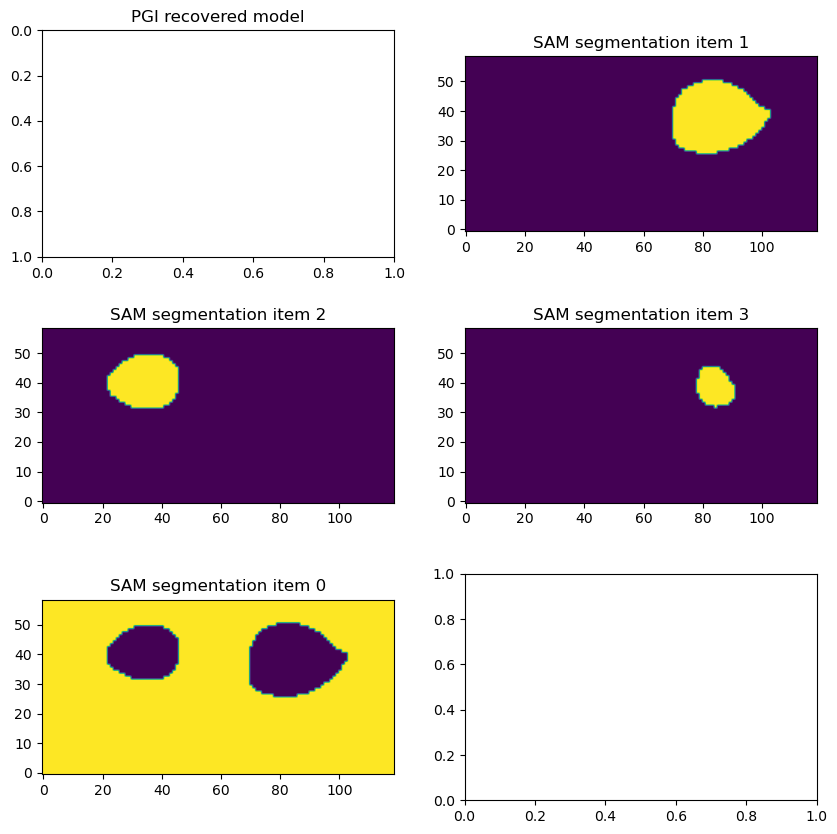

In [ ]:
# print(np.nonzero([0,1,2,3]))
# sub = np.asarray([[1,         0,         0.2254902,  0.63354037],
#  [0,         1.,        0,         0.36326109],
#  [0.2254902,  0,         1,         0.14285714],
#  [0.63354037, 0.36326109, 0.14285714, 1.        ]])

# print(np.nonzero(sub[0, :])[0].shape[0])
# # looking at things
# len(gmmref.masks)
result = gmmref.masks
fig, ax = plt.subplots(3,2, figsize=(10, 10))
result[0].keys()
# ax[0, 0].imshow(np.log(model.reshape(self.mesh.shape_cells, order='F')).T)
ax[0, 0].invert_yaxis()
ax[0, 0].set_title('PGI recovered model')

# for i in range(4):
ax[0, 1].imshow(result[1]['segmentation'].T)
ax[0, 1].invert_yaxis()
ax[0, 1].set_title('SAM segmentation item 1')
ax[1, 0].imshow(result[2]['segmentation'].T)
ax[1, 0].invert_yaxis()
ax[1, 0].set_title('SAM segmentation item 2')
ax[1, 1].imshow(result[3]['segmentation'].T)
ax[1, 1].invert_yaxis()
ax[1, 1].set_title('SAM segmentation item 3')
ax[2, 0].imshow(result[0]['segmentation'].T)
ax[2, 0].invert_yaxis()
ax[2, 0].set_title('SAM segmentation item 0')
ax[2, 1].imshow(result[4]['segmentation'].T)
ax[2, 1].invert_yaxis()
ax[2, 1].set_title('SAM segmentation item 0')
plt.tight_layout()
plt.show()

In [9]:
# Setup the inversion proceedure
# Define a counter
# Data misfit
dmis = data_misfit.L2DataMisfit(data=dpred, simulation=sim)
# Regularization
regmap = maps.IdentityMap(nP=int(actcore.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)

reg = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=actcore,
    mapping=regmap,
    reference_model=m0
)
reg.alpha_s = 1/csx**2
reg.alpha_x = 100
reg.alpha_y = 100
reg.alpha_z = 100

# Optimization object
opt = optimization.ProjectedGNCG(maxIter=10, lower=-10, upper=10,
                                 maxIterLS=20, maxIterCG=100, tolCG=1e-5)

opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg,  opt)
invProb.beta = 1e2

# Inversion directives
Target = directives.TargetMisfit()
betaSched = directives.BetaSchedule(coolingFactor=2.,  coolingRate=1.)
updateSensW = directives.UpdateSensitivityWeights(threshold=1e-3,everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
inv = inversion.BaseInversion(invProb,  directiveList=[updateSensW, 
                                                       Target,
                                                       betaSched,
                                                       update_Jacobi,
                                                       ])

import time
start = time.time()
# Run the inversion
mopt = inv.run(m0)
print('Inversion took {0} seconds'.format(time.time() - start))

c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\SimPEG\directives\directives.py:2519: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\SimPEG\directives\directives.py:2526: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  warnings.warn(



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+02  8.36e+04  0.00e+00  8.36e+04    8.68e+02      0              
   1  5.00e+01  5.10e+03  5.80e+01  8.00e+03    3.43e+02      0              
   2  2.50e+01  1.15e+03  8.79e+01  3.35e+03    1.62e+02      0              
   3  1.25e+01  3.91e+02  1.07e+02  1.72e+03    1.01e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 8.3579e+03
1 : |xc-x_last| = 7.4243e+00 <= tolX*(1+|x0|) = 4.6312e+01
0 : |proj(x-g)-x|

C:\Users\johnk\AppData\Local\Temp\ipykernel_1788\2632781698.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(mopt, ax=ax, pcolorOpts={'cmap':"Spectral"})


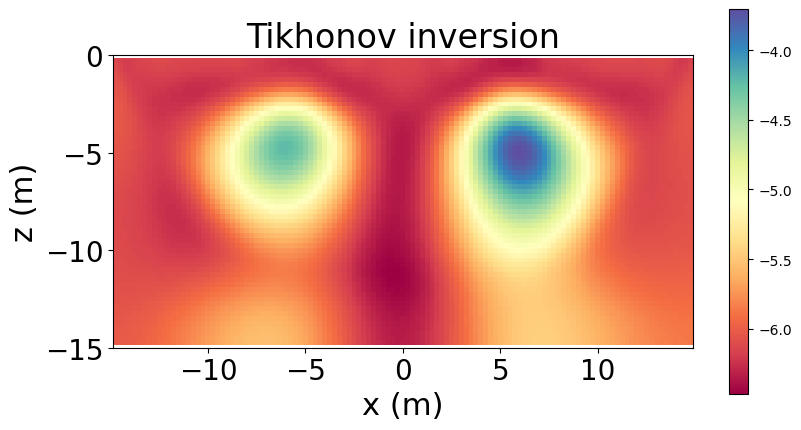

In [11]:
# Plot the recovered model
clim = [1, 500]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mopt, ax=ax, pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Tikhonov inversion',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)

C:\Users\johnk\AppData\Local\Temp\ipykernel_1788\2430852653.py:3: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(np.log(sensweights), ax=ax, contour=True)


(0.0, 1.0, 0.0, 1.0)

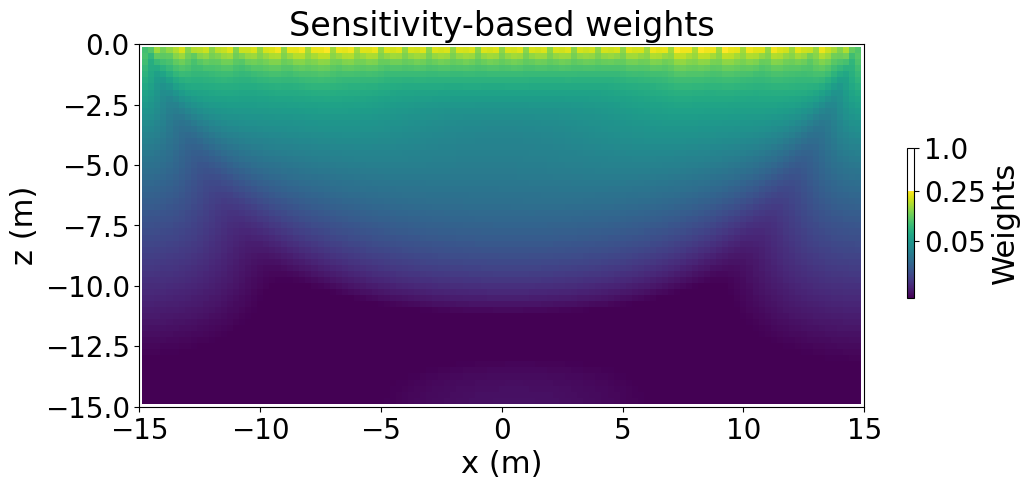

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sensweights = sp.csr_matrix.diagonal(reg.objfcts[0].W)
dat = meshCore.plotImage(np.log(sensweights), ax=ax, contour=True)
ax.set_title('Sensitivity-based weights',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = plt.colorbar(dat[0], ax=cbar_ax)
cb.set_label('Weights',fontsize=22)
cb.set_ticks([np.log(0.05),np.log(0.25),np.log(1)], )
cb.set_ticklabels([0.05,0.25,1.],)
cb.ax.tick_params(labelsize=20)
cbar_ax.axis('off')

#### Directives

In [13]:
from SimPEG.regularization import (

    PGIsmallness,
)
# -----------------------------------------------------------------------

# creating directives and additional classes

#

#plot learned mref
class plot_mref(directives.InversionDirective):
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            self.opt.xc, ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            pcolor_opts={'cmap':'Spectral'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            self.invProb.reg.objfcts[0].mref, ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            pcolor_opts={'cmap':'Spectral'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        utils.plot2Ddata(
            meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
            contourOpts={'alpha':0},
            #clim=[0,5],
            ax=ax[0],
            level=True,
            ncontour=2,
            levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
            method='nearest'
        )

        ax[2].hist(self.opt.xc, 100)
        # ax[2].set_aspect(1)

        ax[0].set_ylim([-15,0])
        ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        ax[1].set_ylim([-15,0])
        ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        plt.show()

# update the neighbors

class update_gmmrf_neighbours(directives.InversionDirective):
    
    def initialize(self):
        self.count = 0
        # self.endIter()

        pgi_reg = self.reg.get_functions_of_type(PGIsmallness)
        if len(pgi_reg) != 1:
            raise UserWarning(
                "'PGI_UpdateParameters' requires one 'PGIsmallness' regularization "
                "in the objective function."
            )
        self.pgi_reg = pgi_reg[0]
    
    def endIter(self):

        print(f"iteration: {self.opt.iter}")
        if self.count > 2:

            self.pgi_reg.gmmref.update_neighbors_index(self.opt.xc)

        else:

            self.count += 1

        # self.pgi_reg.gmmref.fit(self.opt.xc.reshape(-1, 1))

        # Manually setting the GMM parameters
        ## Order cluster by order of importance
        # self.pgi_reg.gmmref.order_clusters_GM_weight()
        # ## Set cluster means
        # self.pgi_reg.gmmref.means = np.r_[-np.log(50.), -np.log(90.), -np.log(500.)][:,np.newaxis]

        # self.pgi_reg.gmmref.covariances_ = np.array([[[0.001]],
        #                             [[0.001]],
        #                             [[0.001]],])
        # ##Set clusters precision and Cholesky decomposition from variances
        # self.pgi_reg.gmmref.compute_clusters_precisions()
        # clf_nguyen.weights_ = np.ones_like(clf_nguyen.weights_) * clf.weights_
        # self.pgi_reg.gmmref.weights_ /= gmmref.weights_.sum(axis=1)[:,np.newaxis]
        self.pgi_reg.gmm = self.pgi_reg.gmmref


ValueError: operands could not be broadcast together with shapes (1000,3) (7021,3) 

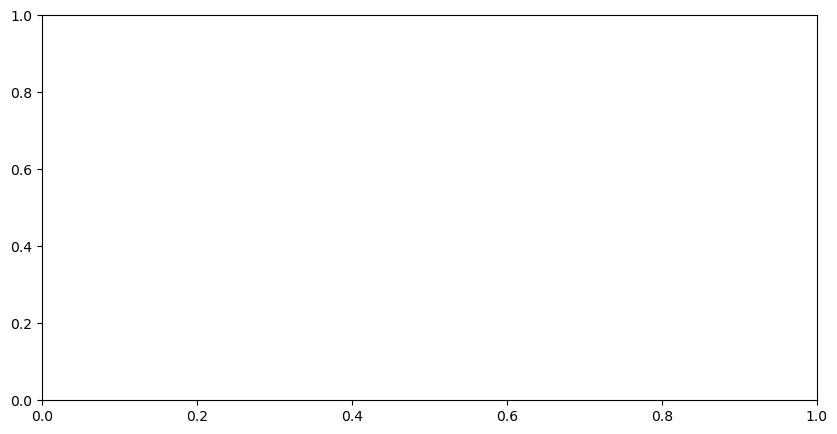

In [14]:
# Plot the histogram of the Tikhonov recovered model

fig, ax = plt.subplots(1,1,figsize=(10,5))

testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]

ax.plot(testXplot, np.exp(gmmref.score_samples(-np.log(testXplot))),
        linewidth=2,label='True petrophysical\ndistribution',c='k'
)
ax.set_xlabel('Resistivity (Ohm-m)',fontsize=22)
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="major",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,500])
hist, edges = np.histogram(np.exp(mopt),bins=32, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), 
       ec="k", align="edge",label='Tikhonov recovered\ngeophysical model',color='#4878CF'
)
ax.legend(loc=0,fontsize=20)
ax.set_ylim([0.,12.])

c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\SimPEG\utils\code_utils.py:642: FutureWarning: active_cells.indActive has been deprecated, please use active_cells. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)
c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\SimPEG\utils\code_utils.py:651: FutureWarning: active_cells.indActive has been deprecated, please use active_cells. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)
c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\SimPEG\directives\directives.py:2519: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\SimPEG\directives\directives.py:2526: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  warnings.warn(



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
<class 'SimPEG.regularization.pgi.PGIsmallness'>
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  7.61e+05  0.00e+00  7.61e+05    8.56e+04      0              
iteration: 1


 Smallness!!!! 


geophys. misfits: 44965.9 (target 209.5 [False]) | smallness misfit: 504639.5 (target: 3510.5 [False])
Beta cooling evaluation: progress: [44965.9] ; minimum progress targets: [684662.3]
mref changed in  0  places


c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\SimPEG\utils\code_utils.py:642: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)


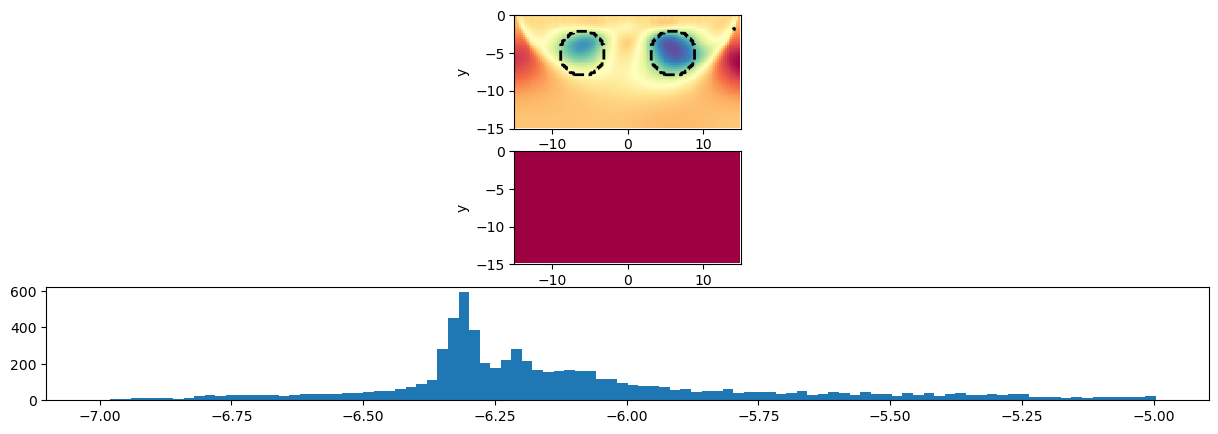

   1  1.00e-02  4.50e+04  1.58e+04  4.51e+04    1.02e+04      0              
iteration: 2


 Smallness!!!! 


geophys. misfits: 1130.0 (target 209.5 [False]) | smallness misfit: 1246580.1 (target: 3510.5 [False])
Beta cooling evaluation: progress: [1130.] ; minimum progress targets: [40469.3]
mref changed in  0  places


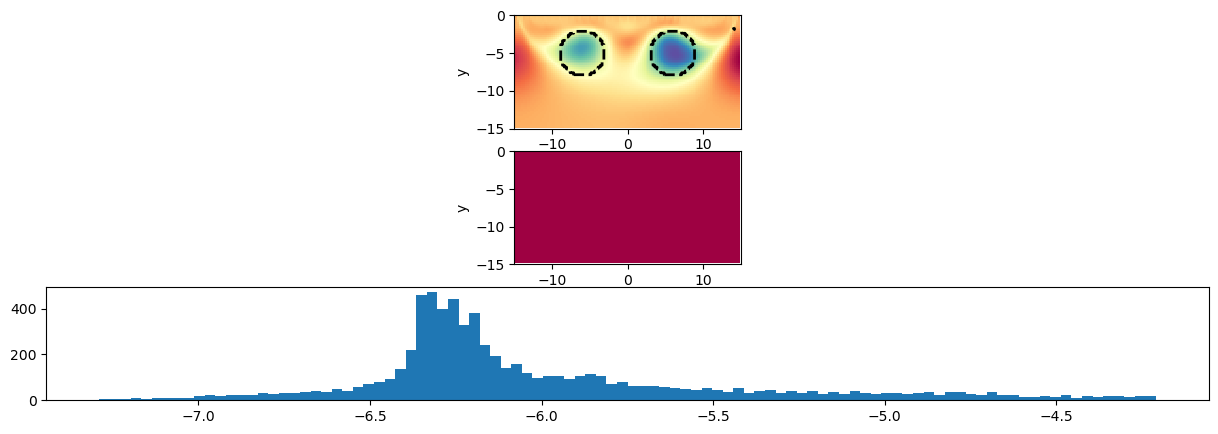

   2  1.00e-02  1.13e+03  3.90e+04  1.52e+03    1.04e+03      0   Skip BFGS  
iteration: 3


 Smallness!!!! 


in something else
prediction modified
geophys. misfits: 189.6 (target 209.5 [True]) | smallness misfit: 384771.1 (target: 3510.5 [False])
Beta cooling evaluation: progress: [189.6] ; minimum progress targets: [1017.]
Warming alpha_pgi to favor clustering:  1.1049237470317042
mref changed in  973  places


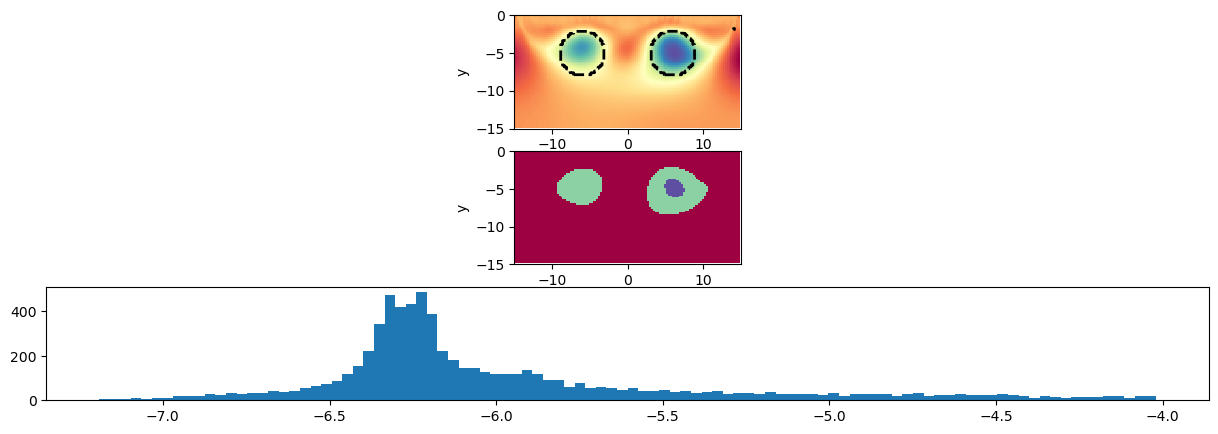

   3  1.00e-02  1.90e+02  1.33e+04  3.22e+02    2.09e+02      0   Skip BFGS  
iteration: 4


 Smallness!!!! 


geophys. misfits: 94.0 (target 209.5 [True]) | smallness misfit: 248707.9 (target: 3510.5 [False])
Beta cooling evaluation: progress: [94.] ; minimum progress targets: [220.]
Warming alpha_pgi to favor clustering:  2.463805863712822
mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells


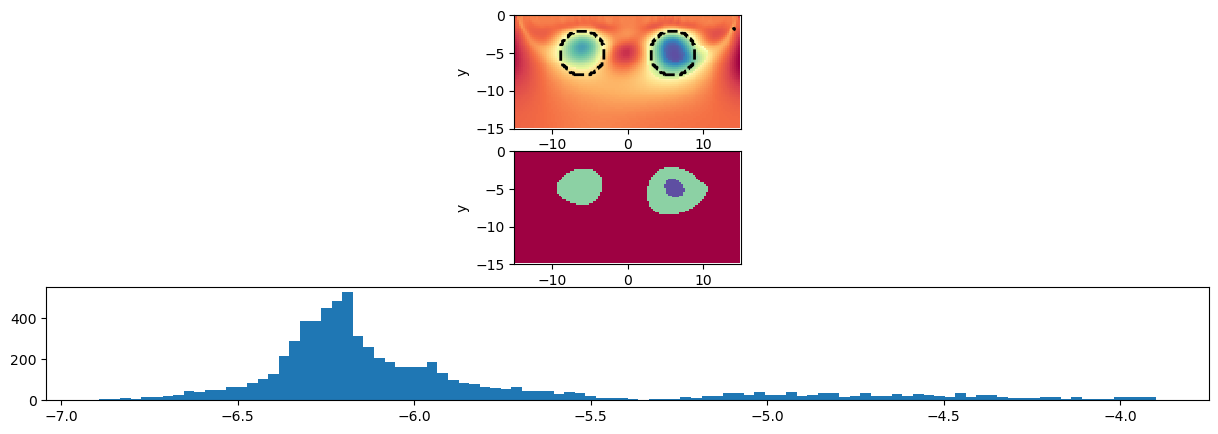

   4  1.00e-02  9.40e+01  1.92e+04  2.85e+02    2.62e+02      0              
iteration: 5


 removal




 Smallness!!!! 


geophys. misfits: 64.3 (target 209.5 [True]) | smallness misfit: 132936.7 (target: 3510.5 [False])
Beta cooling evaluation: progress: [64.3] ; minimum progress targets: [220.]
Warming alpha_pgi to favor clustering:  8.02759359259486
mref changed in  0  places
Add mref to Smoothness. Changes in mref happened in 0.0 % of the cells


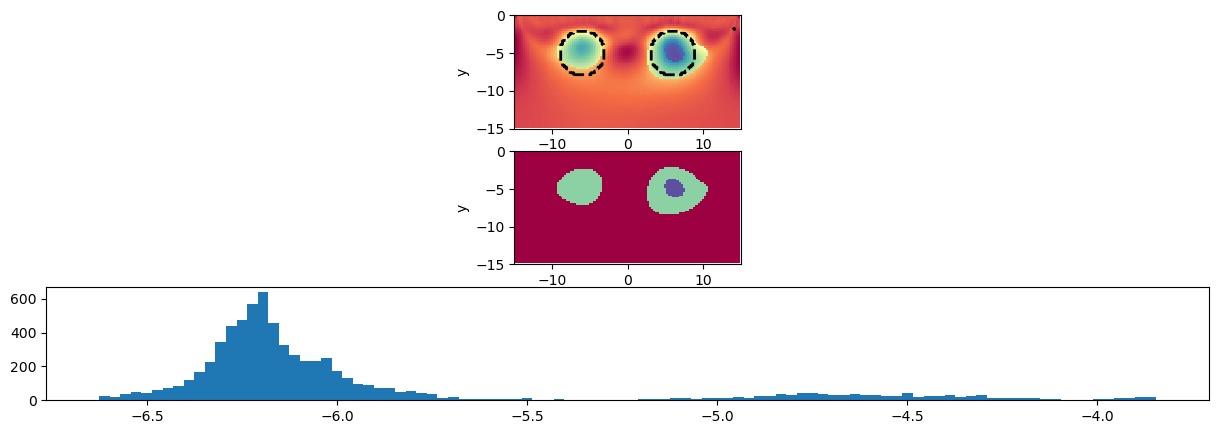

   5  1.00e-02  6.43e+01  3.34e+04  3.98e+02    2.42e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.1238e+02 <= tolF*(1+|f0|) = 7.6074e+04
1 : |xc-x_last| = 7.3452e+00 <= tolX*(1+|x0|) = 5.2173e+01
0 : |proj(x-g)-x|    = 2.4186e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.4186e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------


In [15]:
log_conductivity_background = np.log(1 / 500)

m0 = log_conductivity_background * np.ones(mapping.nP)
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))
reg_mean = regularization.PGI(
    gmm=gmmref,
    gmmref=gmmref,  mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap],
    reference_model=m0,
    indActive=actcore
)

# Weighting
reg_mean.alpha_s = 0.016
reg_mean.alpha_x = 100
reg_mean.alpha_y = 100
# reg_mean.mrefInSmooth = True
# reg_mean.approx_gradient = True


# Optimization
opt = optimization.ProjectedGNCG(maxIter=5, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)

# Inversion directives
betaIt = directives.PGI_BetaAlphaSchedule(
    verbose=True, coolingFactor=5.,
    warmingFactor=1., tolerance=0.05,
    progress=0.1
)
targets = directives.MultiTargetMisfits(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
petrodir = directives.PGI_UpdateParameters(
    update_covariances=True,
    kappa = 1e8,
    nu = 1e8,
    update_rate = 3,
    # update_reference_model=(False)
    )
update_sam = update_gmmrf_neighbours()
plot_iter_mref = plot_mref()
updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
invProb.beta = 1e-2
inv = inversion.BaseInversion(invProb,
                              directiveList=[
                                             updateSensW,
                                             update_sam,
                                             petrodir,
                                             targets, betaIt,
                                             MrefInSmooth,
                                             plot_iter_mref,
                                             update_Jacobi,
                                             ])

# Run!
mcluster = inv.run(m0)

prediction modified
prediction modified


C:\Users\johnk\AppData\Local\Temp\ipykernel_1788\98757483.py:34: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(mopt), ax=ax[1], pcolorOpts={'cmap':"Spectral"})
C:\Users\johnk\AppData\Local\Temp\ipykernel_1788\98757483.py:43: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(mtrue[actcore]), ax=ax[0], clim=clim, pcolorOpts={'cmap':"Spectral"})
C:\Users\johnk\AppData\Local\Temp\ipykernel_1788\98757483.py:52: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(refm), clim=clim, ax=ax[2], pcolorOpts={'cmap':"Spectral"})
C:\Users\johnk\AppData\Local\Temp\ipykernel_1788\98757483.py:61: FutureWarning: Tensor

[[500.14169558]
 [ 50.05487391]
 [ 89.95922222]]
[[500.14169558]
 [ 50.05487391]
 [ 89.95922222]]


(<matplotlib.contour.QuadContourSet at 0x1e224538dc0>,
 <Axes: title={'center': 'd) Petrophysically constrained - GMMRF+SAM'}, xlabel='x', ylabel='y'>,
 <matplotlib.contour.QuadContourSet at 0x1e2245201c0>)

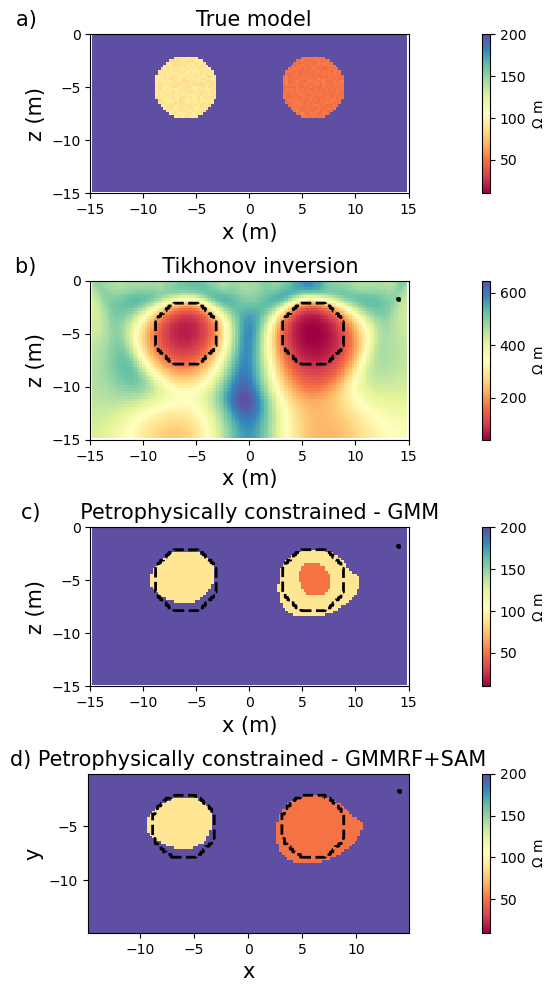

In [40]:
# clim = [mtrue.min(), mtrue.max()]
# fig, ax = plt.subplots(1,1,figsize=(10,5))
# dat = meshCore.plotImage(mcluster, ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral"})
# plt.colorbar(dat[0])
# ax.set_title('Petrophysically constrained - GMMRF-SAM',fontsize=20)
# ax.set_aspect('equal')
# ax.set_ylim([-15,0])
# ax.set_xlim([-15,15])
# ax.set_xlabel('x (m)',fontsize=22)
# ax.set_ylabel('z (m)',fontsize=22)

# utils.plot2Ddata(
#             meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
#             contourOpts={'alpha':0},
#             #clim=[0,5],
#             ax=ax,
#             level=True,
#             ncontour=2,
#             levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#             method='nearest'
#         )

# ax.tick_params(labelsize=20)
# fig.subplots_adjust(right=0.85)
# plt.show()
membership = invProb.reg.gmmref.predict(mcluster.reshape(-1, 1))
membership_gmm = invProb.reg.gmm.predict(mcluster.reshape(-1, 1))
refm = invProb.reg.gmm.means_[membership]
refm_gmm = invProb.reg.gmm.means_[membership_gmm]

clim = [10, 200]
fig, ax = plt.subplots(4,1,figsize=(15,10))

dat = meshCore.plotImage(1 / np.exp(mopt), ax=ax[1], pcolorOpts={'cmap':"Spectral"})
ax[1].set_title('b)                   Tikhonov inversion                   ',fontsize=15)
ax[1].set_aspect('equal')
ax[1].set_ylim([-15,0])
ax[1].set_xlim([-15,15])
ax[1].set_xlabel('x (m)',fontsize=15)
ax[1].set_ylabel('z (m)',fontsize=15)
plt.colorbar(dat[0], label=r'$\Omega$ m')

dat = meshCore.plotImage(1 / np.exp(mtrue[actcore]), ax=ax[0], clim=clim, pcolorOpts={'cmap':"Spectral"})
ax[0].set_aspect('equal')
ax[0].set_ylim([-15,0])
ax[0].set_xlim([-15,15])
ax[0].set_xlabel('x (m)',fontsize=15)
ax[0].set_ylabel('z (m)',fontsize=15)
ax[0].set_title('a)                        True model                          ',fontsize=15)
plt.colorbar(dat[0], label=r'$\Omega$ m')

dat = meshCore.plotImage(1 / np.exp(refm), clim=clim, ax=ax[2], pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0], label=r'$\Omega$ m')
ax[3].set_title('d) Petrophysically constrained - GMMRF+SAM',fontsize=15)
ax[3].set_aspect('equal')
ax[3].set_ylim([-15,0])
ax[3].set_xlim([-15,15])
ax[3].set_xlabel('x (m)',fontsize=15)
ax[3].set_ylabel('z (m)',fontsize=15)

dat = meshCore.plotImage(1 / np.exp(refm_gmm), clim=clim, ax=ax[3], pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0], label=r'$\Omega$ m')
ax[2].set_title('c)      Petrophysically constrained - GMM      ',fontsize=15)
ax[2].set_aspect('equal')
ax[2].set_ylim([-15,0])
ax[2].set_xlim([-15,15])
ax[2].set_xlabel('x (m)',fontsize=15)
ax[2].set_ylabel('z (m)',fontsize=15)
fig.tight_layout(pad=1.0)
print(1 / np.exp(invProb.reg.gmmref.means_))
print(1 / np.exp(invProb.reg.gmm.means_))

utils.plot2Ddata(
            meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
            contourOpts={'alpha':0},
            #clim=[0,5],
            ax=ax[1],
            level=True,
            ncontour=2,
            levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
            method='nearest'
        )

utils.plot2Ddata(
            meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
            contourOpts={'alpha':0},
            #clim=[0,5],
            ax=ax[2],
            level=True,
            ncontour=2,
            levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
            method='nearest'
        )


utils.plot2Ddata(
            meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
            contourOpts={'alpha':0},
            #clim=[0,5],
            ax=ax[3],
            level=True,
            ncontour=2,
            levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
            method='nearest'
        )

C:\Users\johnk\AppData\Local\Temp\ipykernel_12124\3691874045.py:3: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(mcluster, ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral"})
c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\discretize\utils\code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


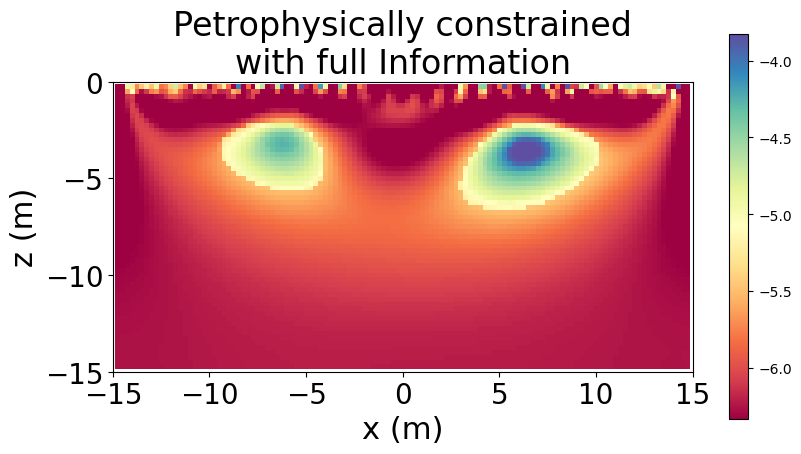

In [ ]:
clim = [mtrue.min(), mtrue.max()]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(mcluster, ax=ax, clim=clim, pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Petrophysically constrained\nwith full Information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.show()

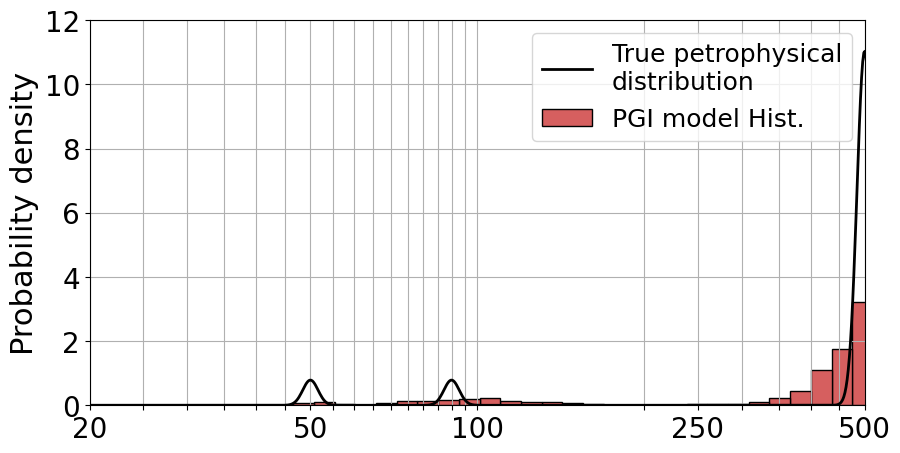

In [21]:
# plot the histogram of the PGI recovered model
fig, ax = plt.subplots(1,1,figsize=(10,5))
testXplot = np.logspace(1, 3, 1000,base=10)[:,np.newaxis]
ax.plot(testXplot, np.exp(gmmref.score_samples(-np.log(testXplot))),linewidth=2,label='True petrophysical\ndistribution',c='k')
ax.tick_params(labelsize=20)
ax.set_ylabel('Probability density',fontsize=22)
ax.set_xscale('log')
ax.grid(True,which='both')
ax.grid(True,which="major",ls="-")
ticks = np.r_[np.linspace(2,10,17)*10,np.linspace(2,9,15)*100]
tickslist = list(ticks)
tcklbl = [''] * len(tickslist)
tcklbl[np.where(ticks==20)[0][0]] = '20'
tcklbl[np.where(ticks==50)[0][0]] = '50'
tcklbl[np.where(ticks==100)[0][0]] = '100'
tcklbl[np.where(ticks==250)[0][0]] = '250'
tcklbl[np.where(ticks==500)[0][0]] = '500'
ax.set_xticks(tickslist)
ax.set_xticklabels(tcklbl)
ax.set_xlim([20,500])
hist, edges = np.histogram(mcluster,bins=32, density=True)
ax.bar(1./np.exp(edges[:-1]), hist, width=np.diff(1./np.exp(edges)), ec="k", align="edge",label='PGI model Hist.',color='#d65f5f')
ax.legend(loc=0,fontsize=18)
ax.set_ylim([0.,12])
plt.show()

C:\Users\johnk\AppData\Local\Temp\ipykernel_13696\666373952.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(classification, ax=ax, pcolorOpts={'cmap':"Spectral"})
c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\discretize\utils\code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


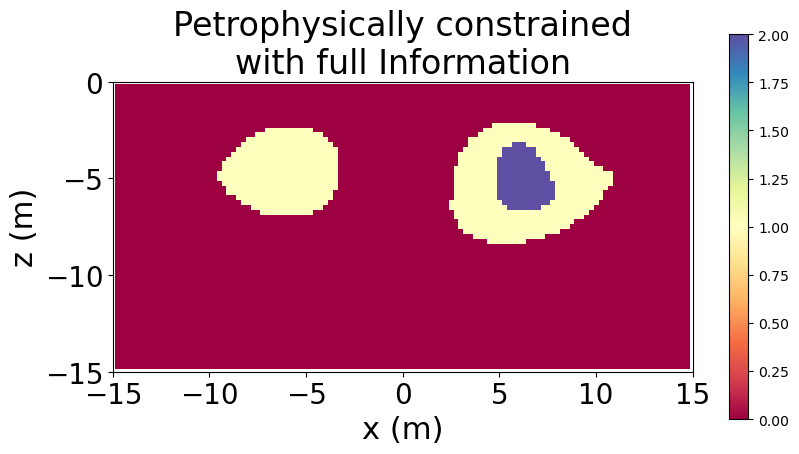

In [22]:
classification = reg_mean.compute_quasi_geology_model()

# clim = [mtrue.min(), mtrue.max()]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(classification, ax=ax, pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Petrophysically constrained\nwith full Information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.show()

[0 0 0 ... 0 0 0]


C:\Users\johnk\AppData\Local\Temp\ipykernel_12124\784308034.py:5: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(classification, ax=ax, pcolorOpts={'cmap':"Spectral"})


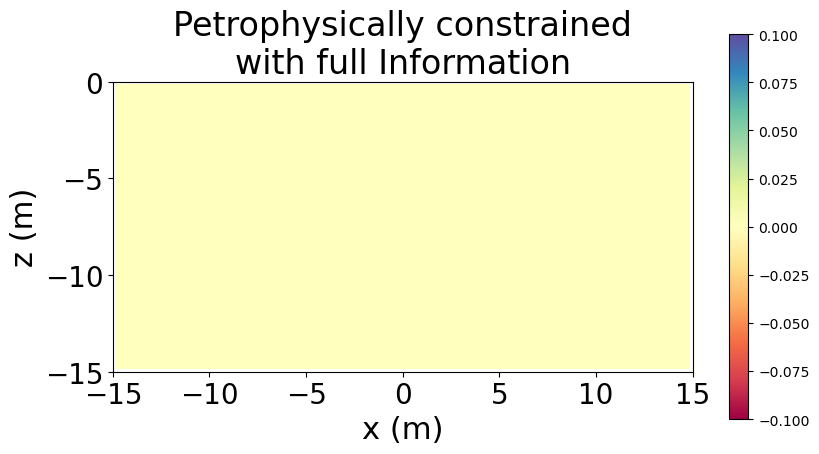

In [ ]:
classification = reg_mean.compute_quasi_geology_model()
print(classification)
# clim = [mtrue.min(), mtrue.max()]
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(classification, ax=ax, pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Petrophysically constrained\nwith full Information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.show()

## segment anything

In [ ]:
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from matplotlib import cm
import cv2

sam = sam_model_registry["vit_h"](checkpoint=r"C:\Users\johnk\Documents\git\jresearch\PGI\dcip\sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)

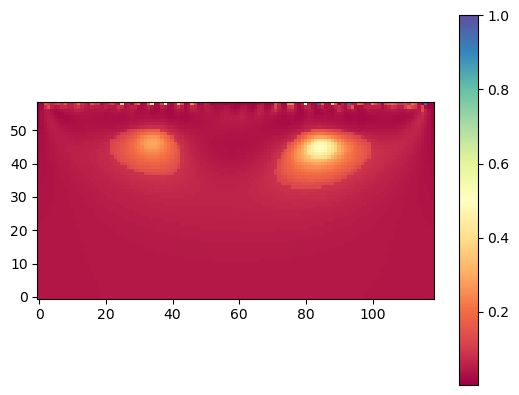

In [ ]:

myarray = np.exp(mcluster) / np.abs(np.exp(mcluster)).max()

image_rgb = Image.fromarray(np.uint8(cm.jet(myarray.reshape(meshCore.shape_cells, order='F'))*255))
image_rgb = image_rgb.convert('RGB')
plt.imshow(myarray.reshape(meshCore.shape_cells, order='F').T, cmap='Spectral')
plt.gca().invert_yaxis()
# plt.savefig('test_image.png')
result = mask_generator.generate(np.asarray(image_rgb))
# print(input_image.shape)

plt.colorbar()

In [ ]:
# !pip install supervision
# import supervision as sv
print(result[0].keys(), result[1]['area'])
# for i in range(4):
#     plt.imshow(result[i]['predicted_iou'].T)
#     plt.gca().invert_yaxis()
#     plt.show()
# mask_annotator = sv.MaskAnnotator()
# detections = sv.Detections.from_sam(result)
# annotated_image = mask_annotator.annotate(image_bgr, detections)



def calculate_iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) between two binary masks.

    Parameters:
        mask1 (numpy.ndarray): The first binary mask.
        mask2 (numpy.ndarray): The second binary mask.

    Returns:
        float: The Intersection over Union (IoU) score.
    """
    # Ensure the masks have the same shape
    if mask1.shape != mask2.shape:
        raise ValueError("Mask shapes do not match.")

    # Convert masks to binary (0 or 1) values
    mask1 = np.array(mask1 > 0, dtype=np.uint8)
    mask2 = np.array(mask2 > 0, dtype=np.uint8)

    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    iou = intersection / union if union > 0 else 0.0
    return iou

# ---------------------------------------------------------------------------------------------

# create a matrix that holds information about overlapping mask if they happen to

# this is done using intersection over union method

#

onion = np.zeros((4,4))
for ii in range(4):
    for jj in range(4):
        iou_score = calculate_iou(result[ii]['segmentation'], result[jj]['segmentation'])
        onion[ii, jj] = iou_score
        print("IoU score:", iou_score)

print(onion)

# plt.hist(mcluster.reshape(meshCore.shape_cells, order='F')[result[2]['segmentation']], 100)
# plt.show()
# print(1 / np.exp(mcluster.reshape(meshCore.shape_cells, order='F')[result[2]['segmentation']].min()))
# print(1 / np.exp(mcluster.reshape(meshCore.shape_cells, order='F')[result[2]['segmentation']].max()))
# print(np.var(mcluster.reshape(meshCore.shape_cells, order='F')[result[2]['segmentation']]))

# plt.hist(mcluster.reshape(meshCore.shape_cells, order='F')[result[3]['segmentation']], 100)
# plt.show()
# print(1 / np.exp(mcluster.reshape(meshCore.shape_cells, order='F')[result[3]['segmentation']].min()))
# print(1 / np.exp(mcluster.reshape(meshCore.shape_cells, order='F')[result[3]['segmentation']].max()))
# print(np.var(mcluster.reshape(meshCore.shape_cells, order='F')[result[3]['segmentation']]))


dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box']) 236
IoU score: 1.0
IoU score: 0.033555105582875326
IoU score: 0.04424016087331226
IoU score: 0.0
IoU score: 0.033555105582875326
IoU score: 1.0
IoU score: 0.0
IoU score: 0.0
IoU score: 0.04424016087331226
IoU score: 0.0
IoU score: 1.0
IoU score: 0.125
IoU score: 0.0
IoU score: 0.0
IoU score: 0.125
IoU score: 1.0
[[1.         0.03355511 0.04424016 0.        ]
 [0.03355511 1.         0.         0.        ]
 [0.04424016 0.         1.         0.125     ]
 [0.         0.         0.125      1.        ]]


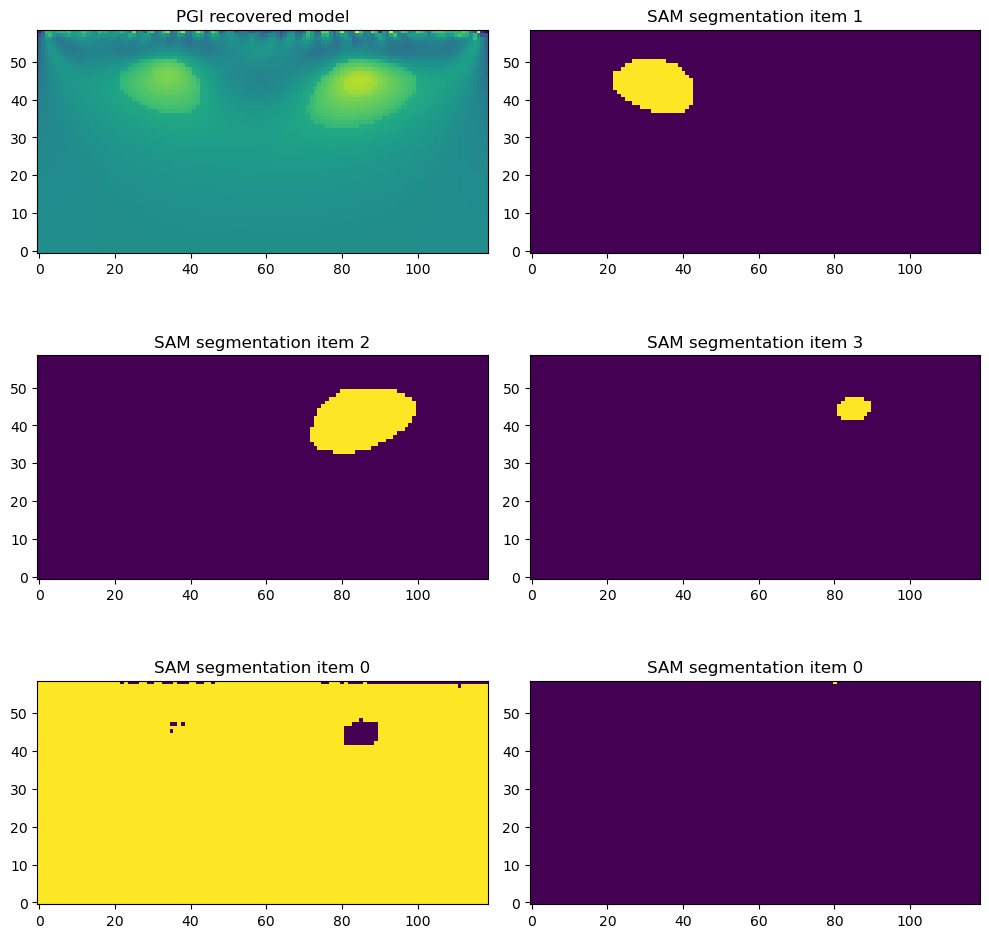

In [ ]:
from scipy import stats
# print(np.bincount(onion.flatten()))

fig, ax = plt.subplots(3,2, figsize=(10, 10))
result[0].keys()
ax[0, 0].imshow(np.log(myarray.reshape(meshCore.shape_cells, order='F')).T)
ax[0, 0].invert_yaxis()
ax[0, 0].set_title('PGI recovered model')

# for i in range(4):
ax[0, 1].imshow(result[1]['segmentation'].T)
ax[0, 1].invert_yaxis()
ax[0, 1].set_title('SAM segmentation item 1')
ax[1, 0].imshow(result[2]['segmentation'].T)
ax[1, 0].invert_yaxis()
ax[1, 0].set_title('SAM segmentation item 2')
ax[1, 1].imshow(result[3]['segmentation'].T)
ax[1, 1].invert_yaxis()
ax[1, 1].set_title('SAM segmentation item 3')
ax[2, 0].imshow(result[0]['segmentation'].T)
ax[2, 0].invert_yaxis()
ax[2, 0].set_title('SAM segmentation item 0')
ax[2, 1].imshow(result[4]['segmentation'].T)
ax[2, 1].invert_yaxis()
ax[2, 1].set_title('SAM segmentation item 0')
plt.tight_layout()
plt.show()

2
2
[[1.    0.    0.   ]
 [0.    1.    0.125]
 [0.    0.125 1.   ]]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
mask 1 has neighbors: (array([0], dtype=int64),)
mask 2 has neighbors: (array([2], dtype=int64),)
mask 3 has neighbors: (array([2], dtype=int64),)


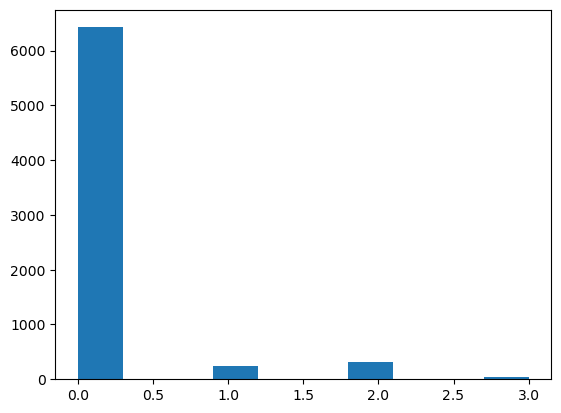

In [ ]:
# ------------------------------------------------------------------------------------

# modify the overlap matrix to assign the proper neighbors mask in the case of onions

#

sub_onion = onion[1:, 1:].copy()

# calculate how many non zero in a row of our overlap matrix
for jj in range(sub_onion.shape[0]):

    if np.count_nonzero(sub_onion[jj, :]) > 1:

        mask_index = np.nonzero(sub_onion[jj, :])
        print(mask_index[0][-1])
        sub_onion[jj, mask_index[0][-1]] = 1
        sub_onion[jj, mask_index[0][0]] = 0

# --------------------------------------------------------------------------------------

# assign each cell a mask to assign it's neighbors

#

hx, hy = meshCore.shape_cells
x = np.arange(hx)
y = np.arange(hy)
xx, yy = np.meshgrid(x, y)

mask_locations = np.vstack([xx.flatten(), yy.flatten()])

mask_assignment = np.zeros(mask_locations.shape[1])

print(onion[1:, 1:])
print(sub_onion)

for ii in range(mask_locations.shape[1]):

    for jj in range(3):

        idx = np.vstack(np.where(result[jj + 1]['segmentation'] == True))

        point_set = idx.T

        # print(point_set.shape, np.vstack(idx).shape, xx.shape)
        distances = np.sqrt(np.sum((point_set - mask_locations[:, ii].T)**2, axis=1))
        # print(jj, mask_assignment[:, ii].T, point_set[0, :])
        min_distance = np.min(distances)
        
        if min_distance == 0:
            mask_assignment[ii] = jj + 1

plt.hist(mask_assignment)


# ---------------------------------------------------------------------------------------

# check which mask has what neighbors

#

for kk in range(sub_onion.shape[0]):

    print(f"mask {kk+1} has neighbors: {np.nonzero(sub_onion[kk, :])}")



2
(2, 236) (236,)


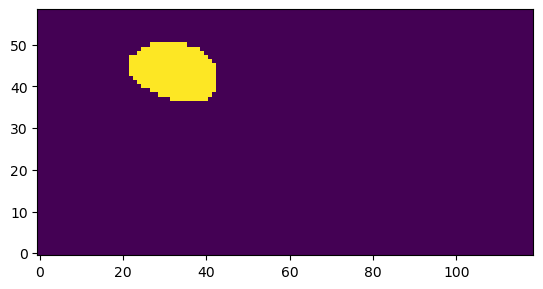

In [ ]:
print(np.nonzero(sub_onion[2, :])[0][0])
idxt = np.vstack(np.where(result[1]['segmentation'] == True))
idxts = np.vstack(np.where(result[1]['segmentation'].flatten() == True))
print(idxt.shape, idxts[0].shape)

flatten = result[1]['segmentation'].flatten(order='F')
reshape = flatten.reshape(meshCore.shape_cells, order='F')
plt.imshow(reshape.T)
plt.gca().invert_yaxis()
# np.random.choice(np.where(result[3]['segmentation'].T == True)[1], 5)
# import numpy as np

# def is_point_in_set(single_point, point_set):
#     single_point = np.array(single_point)
#     point_set = np.array(point_set)
    
#     distances = np.sqrt(np.sum((point_set - single_point)**2, axis=1))
#     min_distance = np.min(distances)
    
#     if min_distance == 0:
#         return True
#     else:
#         return False

# # Example usage:
# single_point = (3, 4)
# point_set = [(1, 2), (5, 6), (3, 4), (7, 8)]

# result = is_point_in_set(single_point, point_set)
# print(result)  # This will print True because (3, 4) is in the set


### complex model segmentation

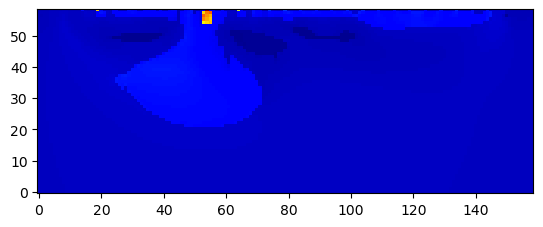

11


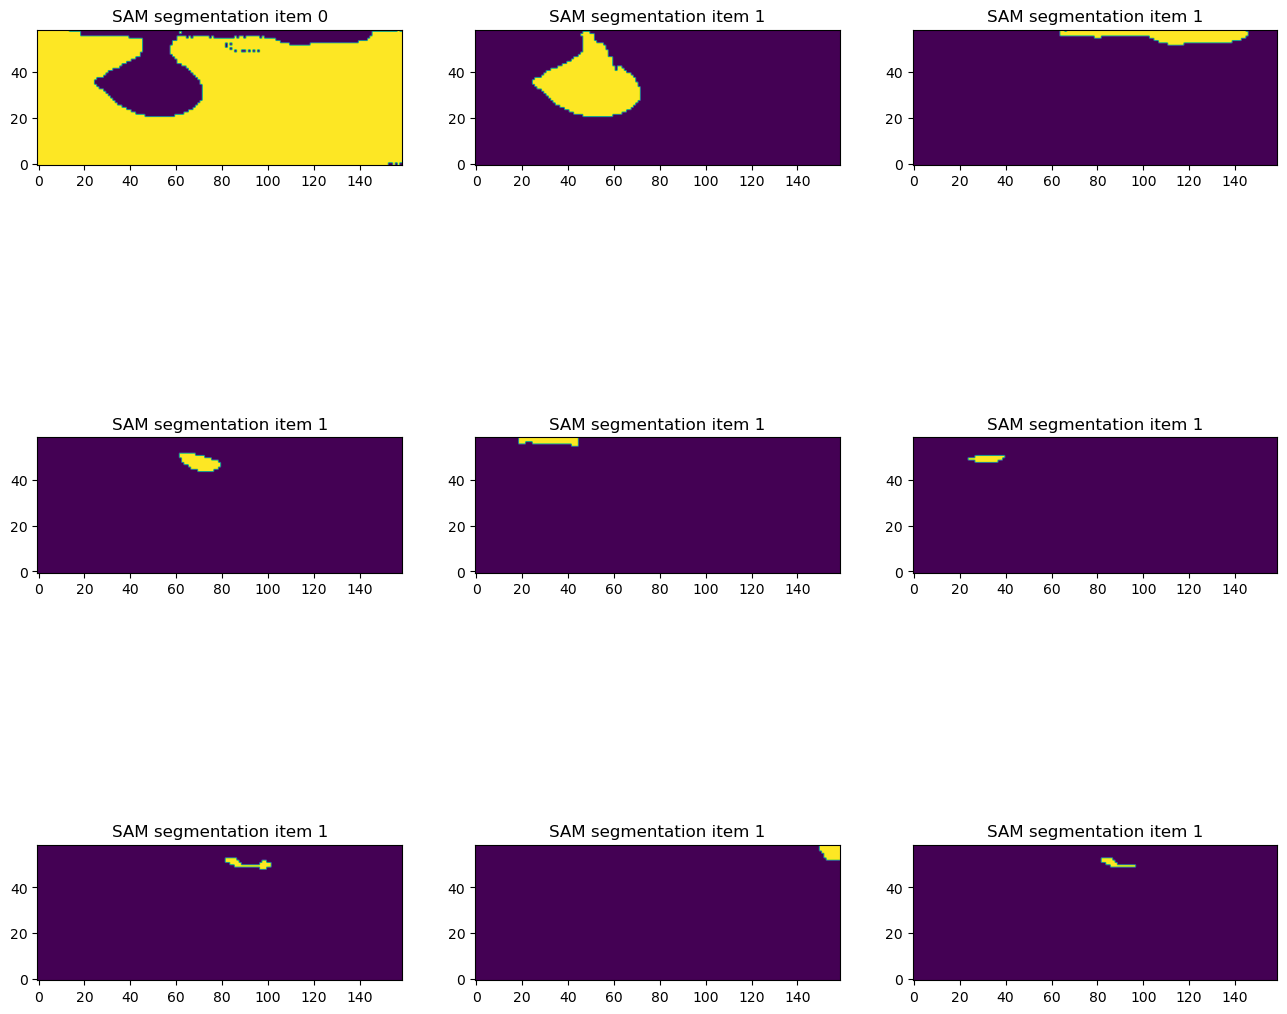

In [ ]:
# image_rgb = np.load('../../complex_geology_prepped.npy')

# print(image_rgb.shape)

# result2 = mask_generator.generate(np.asarray(image_rgb))

plt.imshow(np.moveaxis(image_rgb.T, 0, -1))
plt.gca().invert_yaxis()
plt.show()

fig, ax = plt.subplots(3, 3, figsize=(16, 15))

ax[0, 0].imshow(result2[0]['segmentation'].T)
ax[0, 0].invert_yaxis()
ax[0, 0].set_title('SAM segmentation item 0')
ax[0, 1].imshow(result2[1]['segmentation'].T)
ax[0, 1].invert_yaxis()
ax[0, 1].set_title('SAM segmentation item 1')
ax[0, 2].imshow(result2[2]['segmentation'].T)
ax[0, 2].invert_yaxis()
ax[0, 2].set_title('SAM segmentation item 1')
ax[1, 0].imshow(result2[3]['segmentation'].T)
ax[1, 0].invert_yaxis()
ax[1, 0].set_title('SAM segmentation item 1')
ax[1, 1].imshow(result2[4]['segmentation'].T)
ax[1, 1].invert_yaxis()
ax[1, 1].set_title('SAM segmentation item 1')
ax[1, 2].imshow(result2[5]['segmentation'].T)
ax[1, 2].invert_yaxis()
ax[1, 2].set_title('SAM segmentation item 1')

ax[2, 0].imshow(result2[6]['segmentation'].T)
ax[2, 0].invert_yaxis()
ax[2, 0].set_title('SAM segmentation item 1')
ax[2, 1].imshow(result2[7]['segmentation'].T)
ax[2, 1].invert_yaxis()
ax[2, 1].set_title('SAM segmentation item 1')
ax[2, 2].imshow(result2[9]['segmentation'].T)
ax[2, 2].invert_yaxis()
ax[2, 2].set_title('SAM segmentation item 1')

print(len(result2))





- Use masks as the neighborhood for gmmrf classification

In [ ]:
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from matplotlib import cm


def calculate_iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) between two binary masks.

    Parameters:
        mask1 (numpy.ndarray): The first binary mask.
        mask2 (numpy.ndarray): The second binary mask.

    Returns:
        float: The Intersection over Union (IoU) score.
    """
    
    # Ensure the masks have the same shape
    if mask1.shape != mask2.shape:
        raise ValueError("Mask shapes do not match.")

    # Convert masks to binary (0 or 1) values
    mask1 = np.array(mask1 > 0, dtype=np.uint8)
    mask2 = np.array(mask2 > 0, dtype=np.uint8)

    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    iou = intersection / union if union > 0 else 0.0
    return iou


class GaussianMixtureMarkovRandomField(utils.WeightedGaussianMixture):

    def __init__(
        self,
        n_components,
        mesh,
        actv=None,
        kdtree=None,
        indexneighbors=None,
        boreholeidx=None,
        T=12.,
        masks=None,
        kneighbors=0,
        norm=2,
        init_params='kmeans',
        max_iter=100,
        covariance_type='full',
        means_init=None,
        n_init=10, 
        precisions_init=None,
        random_state=None, 
        reg_covar=1e-06, 
        tol=0.001, 
        verbose=0,
        verbose_interval=10, 
        warm_start=False, 
        weights_init=None,
        anisotropy=None,
        index_anisotropy=None, # Dictionary with anisotropy and index
        index_kdtree=None,# List of KDtree
        segmentation_model_checkpoint=r"C:\Users\johnk\Documents\git\jresearch\PGI\dcip\sam_vit_h_4b8939.pth",
        #**kwargs
    ):

        super(GaussianMixtureMarkovRandomField, self).__init__(
            n_components=n_components,
            mesh=mesh,
            actv=actv,
            covariance_type=covariance_type,
            init_params=init_params,
            max_iter=max_iter,
            means_init=means_init,
            n_init=n_init,
            precisions_init=precisions_init,
            random_state=random_state,
            reg_covar=reg_covar,
            tol=tol,
            verbose=verbose,
            verbose_interval=verbose_interval,
            warm_start=warm_start,
            weights_init=weights_init,
            #boreholeidx=boreholeidx
            # **kwargs
        )
        # setKwargs(self, **kwargs)
        self.kneighbors = kneighbors
        self.T = T
        self.boreholeidx = boreholeidx
        self.anisotropy = anisotropy
        self.norm = norm
        self.masks = masks

        # load segmentation network model
        sam = sam_model_registry["vit_h"](checkpoint=segmentation_model_checkpoint)
        self.mask_generator = SamAutomaticMaskGenerator(sam)

        if self.mesh.gridCC.ndim == 1:
            xyz = np.c_[self.mesh.gridCC]
        elif self.anisotropy is not None:
            xyz = self.anisotropy.dot(self.mesh.gridCC.T).T
        else:
            xyz = self.mesh.gridCC
        
        if self.actv is None:
            self.xyz = xyz
        else:
            self.xyz = xyz[self.actv]
        
        if kdtree is None:
            print('Computing KDTree, it may take several minutes.')
            self.kdtree = spatial.KDTree(self.xyz)
        else:
            self.kdtree = kdtree
        
        if indexneighbors is None:
            print('Computing neighbors, it may take several minutes.')
            _, self.indexneighbors = self.kdtree.query(self.xyz, k=self.kneighbors+1, p=self.norm)
        else:
            self.indexneighbors = indexneighbors

        self.indexpoint = copy.deepcopy(self.indexneighbors)
        self.index_anisotropy = index_anisotropy
        self.index_kdtree = index_kdtree
        if self.index_anisotropy is not None and self.mesh.gridCC.ndim != 1:

            self.unitxyz = []
            for i, anis in enumerate(self.index_anisotropy['anisotropy']):
                self.unitxyz.append((anis).dot(self.xyz.T).T)

            if self.index_kdtree is None:
                self.index_kdtree = []
                print('Computing rock unit specific KDTree, it may take several minutes.')
                for i, anis in enumerate(self.index_anisotropy['anisotropy']):
                    self.index_kdtree.append(spatial.KDTree(self.unitxyz[i]))

            #print('Computing new neighbors based on rock units, it may take several minutes.')
            #for i, unitindex in enumerate(self.index_anisotropy['index']):
        #        _, self.indexpoint[unitindex] = self.index_kdtree[i].query(self.unitxyz[i][unitindex], k=self.kneighbors+1)

    def update_neighbors_index(
            
            self,
            model:np.ndarray
            
    ) -> None:
        """
        
            method that segments the input model and assigns new neighbors described
            by the segmentation map

            :param model: geophysical model
            :type model: np.ndarray

        """

        model_normalized = np.exp(model) / np.abs(np.exp(model)).max()

        image_rgb = Image.fromarray(np.uint8(cm.jet(model_normalized.reshape(self.mesh.shape_cells, order='F'))*255))
        image_rgb = image_rgb.convert('RGB')

        result = self.mask_generator.generate(np.asarray(image_rgb))


        # ---------------------------------------------------------------------------------------------

        # create a matrix that holds information about overlapping mask if they happen to

        # this is done using intersection over union method

        #

        nlayers = self.kneighbors

        union_matrix = np.zeros((nlayers, nlayers))
        for ii in range(nlayers):
            for jj in range(nlayers):
                iou_score = calculate_iou(result[ii]['segmentation'], result[jj]['segmentation'])
                union_matrix[ii, jj] = iou_score
                print("IoU score:", iou_score)

        # ------------------------------------------------------------------------------------

        # modify the overlap matrix to assign the proper neighbors mask in the case of onions

        #

        sub_union_matrix = union_matrix[1:, 1:].copy()

        # calculate how many non zero in a row of our overlap matrix
        for jj in range(sub_onion.shape[0]):

            if np.count_nonzero(sub_onion[jj, :]) > 1:

                mask_index = np.nonzero(sub_union_matrix[jj, :])
                print(mask_index[0][-1])
                sub_union_matrix[jj, mask_index[0][-1]] = 1
                sub_union_matrix[jj, mask_index[0][0]] = 0

        # --------------------------------------------------------------------------------------

        # assign each cell a mask to assign it's neighbors

        #

        hx, hy = mesh.shape_cells
        x = np.arange(hx)
        y = np.arange(hy)
        xx, yy = np.meshgrid(x, y)

        mask_locations = np.vstack([xx.flatten(), yy.flatten()])

        mask_assignment = np.zeros(mask_locations.shape[1])

        for ii in range(mask_locations.shape[1]):

            for jj in range(nlayers - 1):

                idx = np.vstack(np.where(result[jj + 1]['segmentation'] == True))

                point_set = idx.T

                # print(point_set.shape, np.vstack(idx).shape, xx.shape)
                distances = np.sqrt(np.sum((point_set - mask_locations[:, ii].T)**2, axis=1))
                # print(jj, mask_assignment[:, ii].T, point_set[0, :])
                min_distance = np.min(distances)
                
                if min_distance == 0:
                    mask_assignment[ii] = jj + 1

        # ----------------------------------------------------------------------------------------

        # now update the indexpoint matrix

        #

        for kk in range(mask_assignment.shape[0]):

            # check union matrix for the correct mask
            union_index = mask_assignment[kk] - 1
            mask_select = np.nonzero(sub_union_matrix[union_index, :])[0][0]

            idx = np.vstack(np.where(result[mask_select]['segmentation'].flatten(order='F') == True))[0]
            shape_idx = idx.shape[0]

            # if the mask is smaller than the user defined number of neighbors
            if idx.shape[0] < (self.kneighbors + 1):

                self.indexpoint[kk, :] = self.indexpoint[kk, 0]
                self.indexpoint[kk, -shape_idx:] = idx

            # otherwise assign the entire mask
            else:

                self.indexpoint[kk, :] = idx[:(self.kneighbors + 1)]


    def computeG(self, z, w, X):

        #Find neighbors given the current state of data and model
        if self.index_anisotropy is not None and self.mesh.gridCC.ndim != 1:
            prediction = self.predict(X)
            unit_index = []
            for i in range(self.n_components):
                unit_index.append(np.where(prediction==i)[0])
            for i, unitindex in enumerate(unit_index):
                _, self.indexpoint[unitindex] = self.index_kdtree[i].query(
                    self.unitxyz[i][unitindex],
                    k=self.kneighbors+1,
                    p=self.index_anisotropy['norm'][i]
                )

        logG = (self.T/(2.*(self.kneighbors+1))) * (
            (z[self.indexpoint] + w[self.indexpoint]).sum(
                axis=1
            )
        )
        return logG

    def _m_step(self, X, log_resp):
        """M step.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        log_resp : array-like, shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        n_samples, _ = X.shape
        _, self.means_, self.covariances_ = (
            self._estimate_gaussian_parameters(X, self.mesh, np.exp(log_resp), self.reg_covar,self.covariance_type)
        )
        #self.weights_ /= n_samples
        self.precisions_cholesky_ = _compute_precision_cholesky(
            self.covariances_, self.covariance_type)

        logweights = logsumexp(np.c_[[log_resp, self.computeG(np.exp(log_resp), self.weights_,X)]], axis=0)
        logweights = logweights - logsumexp(
            logweights, axis=1, keepdims=True
        )

        self.weights_ = np.exp(logweights)
        if self.boreholeidx is not None:
            aux = np.zeros((self.boreholeidx.shape[0],self.n_components))
            aux[np.arange(len(aux)), self.boreholeidx[:,1]]=1
            self.weights_[self.boreholeidx[:,0]] = aux


    def _check_weights(self, weights, n_components, n_samples):
        """Check the user provided 'weights'.
        Parameters
        ----------
        weights : array-like, shape (n_components,)
            The proportions of components of each mixture.
        n_components : int
            Number of components.
        Returns
        -------
        weights : array, shape (n_components,)
        """
        weights = check_array(
            weights, dtype=[np.float64, np.float32],
            ensure_2d=True
        )
        _check_shape(weights, (n_components, n_samples), 'weights')

    def _check_parameters(self, X):
        """Check the Gaussian mixture parameters are well defined."""
        n_samples, n_features = X.shape
        if self.covariance_type not in ['spherical', 'tied', 'diag', 'full']:
            raise ValueError("Invalid value for 'covariance_type': %s "
                             "'covariance_type' should be in "
                             "['spherical', 'tied', 'diag', 'full']"
                             % self.covariance_type)

        if self.weights_init is not None:
            self.weights_init = self._check_weights(
                self.weights_init,
                n_samples,
                self.n_components
            )

        if self.means_init is not None:
            self.means_init = _check_means(self.means_init,
                                           self.n_components, n_features)

        if self.precisions_init is not None:
            self.precisions_init = _check_precisions(self.precisions_init,
                                                     self.covariance_type,
                                                     self.n_components,
                                                     n_features)

    def _initialize(self, X, resp):
        """Initialization of the Gaussian mixture parameters.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        resp : array-like, shape (n_samples, n_components)
        """
        n_samples, _ = X.shape

        weights, means, covariances = self._estimate_gaussian_parameters(
            X, self.mesh, resp, self.reg_covar, self.covariance_type)
        weights /= n_samples

        self.weights_ = (weights*np.ones((n_samples,self.n_components)) if self.weights_init is None
                         else self.weights_init)
        self.means_ = means if self.means_init is None else self.means_init

        if self.precisions_init is None:
            self.covariances_ = covariances
            self.precisions_cholesky_ = _compute_precision_cholesky(
                covariances, self.covariance_type)
        elif self.covariance_type == 'full':
            self.precisions_cholesky_ = np.array(
                [linalg.cholesky(prec_init, lower=True)
                 for prec_init in self.precisions_init])
        elif self.covariance_type == 'tied':
            self.precisions_cholesky_ = linalg.cholesky(self.precisions_init,
                                                        lower=True)
        else:
            self.precisions_cholesky_ = self.precisions_init


$$g_i = \min_{\boldsymbol{\mu}_n} \big \| \mathbf{m}_i - \boldsymbol{\mu}_n \big \|^2$$

c:\Users\johnk\Anaconda3\envs\jtorch\lib\site-packages\SimPEG\__init__.py


# creating variations on the model

In [ ]:
import itertools
import random
import numpy as np



In [ ]:
# ----------------------------------------------------------------------------------------------

# loop over many placements

#

x = -np.arange(-12, 12.5, 0.5)
z = -np.arange(4, 7.5, 0.5)
res = random.randint(1,90)

# set background unit
log_conductivity_background = -np.log(500)

print(res)

models = []
pgi_geomodel = []

count = 0

for xi, xi1, zi, zi1 in itertools.product(x, x, z, z):

    # print(xi, zi)
    if np.abs(xi - xi1) > 6.5:

        #   2-cylinders Model Creation
        
        # Spheres parameters
        x0,  z0,  r0 = xi,  zi,  3.
        x1,  z1,  r1 = xi1,  zi1,  3.

        ln_sigback = log_conductivity_background
        ln_sigc = -np.log(random.randint(1,90))
        ln_sigr = -np.log(random.randint(1,90))

        # Add some variability to the physical property model
        noisemean = 0.
        noisevar = np.sqrt(0.001)
        ln_over = -2.

        mtrue = ln_sigback * np.ones(mesh.nC) + norm(noisemean, noisevar).rvs(mesh.nC)
        mprim = copy.deepcopy(mtrue)

        csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                        2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
        mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
            norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))

        # Define the sphere limit
        rsph = (np.sqrt((mesh.gridCC[:, 1] - z1) **
                        2. + (mesh.gridCC[:, 0] - x1)**2.)) < r1
        mtrue[rsph] = ln_sigr * np.ones_like(mtrue[rsph]) + \
            norm(noisemean, noisevar).rvs(np.prod((mtrue[rsph]).shape))

        # sphere smaller but higher conductivity
        csph = (np.sqrt((mesh.gridCC[:, 1] - z0) **
                        2. + (mesh.gridCC[:, 0] - x0)**2.)) < r0
        mtrue[csph] = ln_sigc * np.ones_like(mtrue[csph]) + \
            norm(noisemean, noisevar).rvs(np.prod((mtrue[csph]).shape))


        models.append(utils.mkvc(mtrue))

        # -----------------------------------------------------------------

        # forward

        #

        dpred = sim.make_synthetic_data(mtrue[actcore], relative_error=std, force=True)

        # Data misfit
        dmis = data_misfit.L2DataMisfit(data=dpred, simulation=sim)

        # -----------------------------------------------------------------

        # gmm

        #

        # Generate the GMM petrophysical distribution
        n = 3
        gmmref = utils.WeightedGaussianMixture(
            
            n_components=n,
            mesh=mesh,
            actv=actcore,
            covariance_type='full',
            max_iter=1000,
            n_init=10,
            reg_covar=4e-3,

        )

        gmmref.fit(mtrue[actcore].reshape(-1, 1))

        gmmref.means = np.r_[ln_sigc, ln_sigr, ln_sigback][:,np.newaxis]

        gmmref.covariances_ = np.array([[[0.001]],
                                    [[0.001]],
                                    [[0.001]],])

        gmmref.compute_clusters_precisions()

        # -----------------------------------------------------------------

        # inversion

        #

        m0 = log_conductivity_background * np.ones(mapping.nP)
        # Create the regularization with GMM information
        idenMap = maps.IdentityMap(nP=m0.shape[0])
        wires = maps.Wires(('m', m0.shape[0]))
        reg_mean = regularization.PGI(
            gmmref=gmmref,  mesh=mesh,
            wiresmap=wires,
            maplist=[idenMap],
            reference_model=m0,
            indActive=actcore
        )

        # Weighting
        reg_mean.alpha_s = 0.016
        reg_mean.alpha_x = 100
        reg_mean.alpha_y = 100
        # reg_mean.mrefInSmooth = True
        # reg_mean.approx_gradient = True


        # Optimization
        opt = optimization.ProjectedGNCG(maxIter=20, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
        opt.remember('xc')

        # Set the inverse problem
        invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)

        # Inversion directives
        betaIt = directives.PGI_BetaAlphaSchedule(
            verbose=True, coolingFactor=5.,
            warmingFactor=1., tolerance=0.05,
            progress=0.1
        )
        targets = directives.MultiTargetMisfits(
            TriggerSmall=True,
            TriggerTheta=False,
            verbose=True,
        )
        MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
        petrodir = directives.PGI_UpdateParameters(
            update_covariances=True,
            kappa = 1e8,
            nu = 1e8,
            update_reference_model=(False)
            )
        updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
        update_Jacobi = directives.UpdatePreconditioner()
        invProb.beta = 1e-2
        inv = inversion.BaseInversion(invProb,
                                    directiveList=[
                                                    #  updateSensW,
                                                    petrodir,
                                                    targets, betaIt,
                                                    MrefInSmooth,
                                                    #  update_Jacobi,
                                                    ])

        # Run!
        mcluster = inv.run(m0)

        # get the quasi geo-model
        pgi_geomodel.append(reg_mean.compute_quasi_geology_model())

        np.save(f'./training/true_model{count}.npy', utils.mkvc(mtrue))
        np.save(f'./training/pgi_model{count}.npy', reg_mean.compute_quasi_geology_model())

        count += 1

        


19


/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/utils/code_utils.py:642: FutureWarning: active_cells.indActive has been deprecated, please use active_cells. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/utils/code_utils.py:651: FutureWarning: active_cells.indActive has been deprecated, please use active_cells. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/directives/directives.py:2519: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  warnings.warn(
/home/juan/anaconda3/envs/j2/lib/python3.11/site-packages/SimPEG/directives/directives.py:2526: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  warnings.warn(



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
<class 'SimPEG.regularization.pgi.PGIsmallness'>
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-02  2.98e+06  0.00e+00  2.98e+06    4.52e+05      0              
geophys. misfits: 418071.7 (target 209.5 [False]) | smallness misfit: 181447.8 (target: 3510.5 [False])
Beta cooling evaluation: progress: [418071.7]; minimum progress targets: [2684871.1]
mref changed in  96  places
   1  1.00e-02  4.18e+05  1.13e+04  4.18e+05    1.04e+05      0              
geophys. misfits: 179493.0 (target 209.5 [False]) | smallness misfit: 301673.6 (t

In [ ]:
print(len(models))

61740


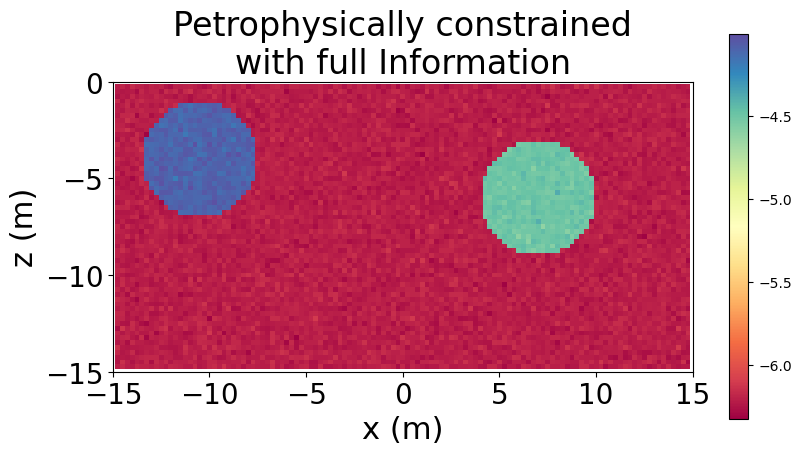

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
dat = meshCore.plotImage(models[16002][actcore], ax=ax, pcolorOpts={'cmap':"Spectral"})
plt.colorbar(dat[0])
ax.set_title('Petrophysically constrained\nwith full Information',fontsize=24)
ax.set_aspect('equal')
ax.set_ylim([-15,0])
ax.set_xlim([-15,15])
ax.set_xlabel('x (m)',fontsize=22)
ax.set_ylabel('z (m)',fontsize=22)
ax.tick_params(labelsize=20)
fig.subplots_adjust(right=0.85)
plt.show()